<a href="https://colab.research.google.com/github/jedi0829/credit-card-fraud-detection/blob/main/credit_card_fraud_analysis_Chang_Liu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# !pip install category_encoders
# !pip install catboost

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xgboost as xgb
import lightgbm as lgb
import category_encoders as ce
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from google.colab import drive

In [7]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
# read data from csv files
# df = pd.read_csv('/content/gdrive/MyDrive/')

df_transactions = pd.read_csv('/content/gdrive/MyDrive/credit_card_transactions-ibm_v2.csv')
df_transactions_user0 = pd.read_csv('/content/gdrive/MyDrive/User0_credit_card_transactions.csv')
df_user_info = pd.read_csv('/content/gdrive/MyDrive/sd254_users.csv')
df_cards_info = pd.read_csv('/content/gdrive/MyDrive/sd254_cards.csv')

## Basic Data Overview

In [9]:
df_transactions.head(5)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [10]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


In [11]:
df_transactions_user0.head(5)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [12]:
df_transactions_user0['User'].unique()

array([0])

In [13]:
df_transactions_user0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19963 entries, 0 to 19962
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   User            19963 non-null  int64  
 1   Card            19963 non-null  int64  
 2   Year            19963 non-null  int64  
 3   Month           19963 non-null  int64  
 4   Day             19963 non-null  int64  
 5   Time            19963 non-null  object 
 6   Amount          19963 non-null  object 
 7   Use Chip        19963 non-null  object 
 8   Merchant Name   19963 non-null  int64  
 9   Merchant City   19963 non-null  object 
 10  Merchant State  18646 non-null  object 
 11  Zip             18316 non-null  float64
 12  MCC             19963 non-null  int64  
 13  Errors?         574 non-null    object 
 14  Is Fraud?       19963 non-null  object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.3+ MB


In [14]:
df_user_info

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Jose Faraday,32,70,1987,7,Male,6577 Lexington Lane,9.0,Freeport,NY,11520,40.65,-73.58,$23550,$48010,$87837,703,3
1996,Ximena Richardson,62,65,1957,11,Female,2 Elm Drive,955.0,Independence,KY,41051,38.95,-84.54,$24218,$49378,$104480,740,4
1997,Annika Russell,47,67,1973,1,Female,276 Fifth Boulevard,NaN,Elizabeth,NJ,7201,40.66,-74.19,$15175,$30942,$71066,779,3
1998,Juelz Roman,66,60,1954,2,Male,259 Valley Boulevard,NaN,Camp Hill,PA,17011,40.24,-76.92,$25336,$54654,$27241,618,1


In [15]:
df_user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Person                       2000 non-null   object 
 1   Current Age                  2000 non-null   int64  
 2   Retirement Age               2000 non-null   int64  
 3   Birth Year                   2000 non-null   int64  
 4   Birth Month                  2000 non-null   int64  
 5   Gender                       2000 non-null   object 
 6   Address                      2000 non-null   object 
 7   Apartment                    528 non-null    float64
 8   City                         2000 non-null   object 
 9   State                        2000 non-null   object 
 10  Zipcode                      2000 non-null   int64  
 11  Latitude                     2000 non-null   float64
 12  Longitude                    2000 non-null   float64
 13  Per Capita Income 

In [16]:
df_cards_info

,User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,1,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,0,2,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,0,3,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,0,4,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6141,1997,1,Amex,Credit,300609782832003,01/2024,663,YES,1,$6900,11/2000,2013,No
6142,1997,2,Visa,Credit,4718517475996018,01/2021,492,YES,2,$5700,04/2012,2012,No
6143,1998,0,Mastercard,Credit,5929512204765914,08/2020,237,NO,2,$9200,02/2012,2012,No
6144,1999,0,Mastercard,Debit,5589768928167462,01/2020,630,YES,1,$28074,01/2020,2020,No


In [17]:
df_cards_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   User                   6146 non-null   int64 
 1   CARD INDEX             6146 non-null   int64 
 2   Card Brand             6146 non-null   object
 3   Card Type              6146 non-null   object
 4   Card Number            6146 non-null   int64 
 5   Expires                6146 non-null   object
 6   CVV                    6146 non-null   int64 
 7   Has Chip               6146 non-null   object
 8   Cards Issued           6146 non-null   int64 
 9   Credit Limit           6146 non-null   object
 10  Acct Open Date         6146 non-null   object
 11  Year PIN last Changed  6146 non-null   int64 
 12  Card on Dark Web       6146 non-null   object
dtypes: int64(6), object(7)
memory usage: 624.3+ KB


#### Check the number of fraudulent transactions

In [18]:
df_transactions['Is Fraud?'].value_counts()

No     24357143
Yes       29757
Name: Is Fraud?, dtype: int64

#### Check missing values by column

In [19]:
df_transactions.isnull().sum()

User                     0
Card                     0
Year                     0
Month                    0
Day                      0
Time                     0
Amount                   0
Use Chip                 0
Merchant Name            0
Merchant City            0
Merchant State     2720821
Zip                2878135
MCC                      0
Errors?           23998469
Is Fraud?                0
dtype: int64

#### Percentage of missing values

<Axes: title={'center': 'Missing Value Analysis'}, xlabel='Features', ylabel='% of missing values'>

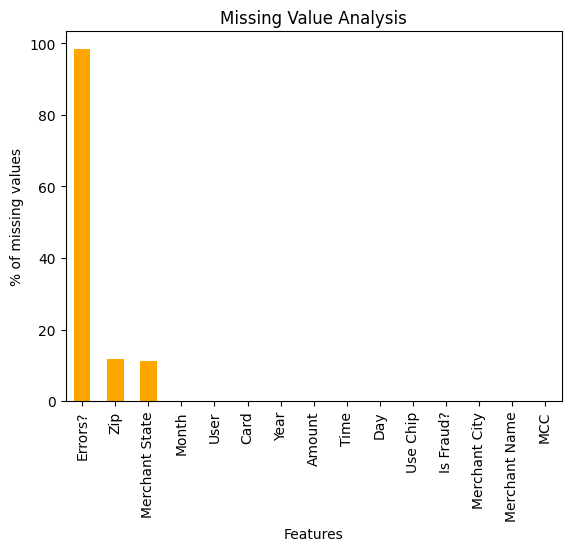

In [20]:
percent_missing = (df_transactions.isnull().sum()*100/df_transactions.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.xticks(rotation=90)

percent_missing.sort_values(ascending=False).plot(kind = 'bar', color = 'orange')

#### Treating missing values

In [21]:
# Errors column
df_transactions[~df_transactions['Errors?'].isnull()].head(5)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
21,0,0,2002,9,9,09:40,$65.50,Swipe Transaction,-3345936507911876459,La Verne,CA,91750.0,7538,Technical Glitch,No
35,0,0,2002,9,12,06:21,$122.10,Swipe Transaction,4060646732831064559,La Verne,CA,91750.0,5411,Insufficient Balance,No
49,0,0,2002,9,17,06:09,$120.19,Swipe Transaction,-34551508091458520,La Verne,CA,91750.0,5912,Insufficient Balance,No
55,0,0,2002,9,20,06:01,$104.77,Swipe Transaction,-245178307025547046,La Verne,CA,91750.0,5311,Insufficient Balance,No
81,0,0,2002,9,29,06:06,$119.61,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,Insufficient Balance,No


Looks like 'Errors?' column is just notes and explanations on what type of transaction erros they are, based on the problems in this analysis, we are not focused on the error types, therefore no need to further treat missing values in this column.

In [22]:
# Zip column
df_transactions['Zip'] = df_transactions['Zip'].fillna(0)

#### Normalize data type for columns

In [23]:
# Amount column: remove the dollar sign and convert it into numeric values
df_transactions['Amount'] = df_transactions['Amount'].str.replace('$', '').astype(float)

<ipython-input-23-4515356a912d>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_transactions['Amount'] = df_transactions['Amount'].str.replace('$', '').astype(float)


In [24]:
# change the 'is fraud' column from text to binary
df_transactions["Is Fraud?"] = df_transactions["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

#### Detecting Outlliers

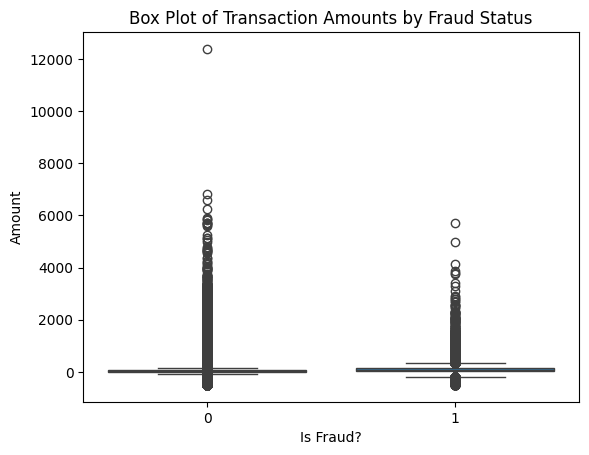

In [25]:
#Transaction amount by fraud or not
df_transactions['Amount'] = pd.to_numeric(df_transactions['Amount'], errors='coerce')
# df_transactions.boxplot(column='Amount', by='Is Fraud?')

sns.boxplot(x = "Is Fraud?",
            y = "Amount",
            data = df_transactions)

plt.title('Box Plot of Transaction Amounts by Fraud Status')
plt.suptitle('')
plt.show()

Looks like there were more outliers in transactions that were not reported as fraud vs. transactions reported as fraud. The box plot shows that most of the fraudulent transactions are concentrated to lower amount.

#### Basic Stats for the transaction data

In [26]:
df_transactions.describe(include='all').fillna("").T.style

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
User,24386900.000000,,,,1001.019335,569.461157,0.000000,510.000000,1006.000000,1477.000000,1999.000000
Card,24386900.000000,,,,1.351366,1.407154,0.000000,0.000000,1.000000,2.000000,8.000000
Year,24386900.000000,,,,2011.955170,5.105921,1991.000000,2008.000000,2013.000000,2016.000000,2020.000000
Month,24386900.000000,,,,6.525064,3.472355,1.000000,3.000000,7.000000,10.000000,12.000000
Day,24386900.000000,,,,15.718123,8.794073,1.000000,8.000000,16.000000,23.000000,31.000000
Time,24386900,1440,12:31,30604,,,,,,,
Amount,24386900.000000,,,,43.634005,82.022390,-500.000000,9.200000,30.140000,65.060000,12390.500000
Use Chip,24386900,3,Swipe Transaction,15386082,,,,,,,
Merchant Name,24386900.000000,,,,-476922962771995648.000000,4758939870684008448.000000,-9222899435637403648.000000,-4500542936415012352.000000,-794676495118551552.000000,3189517333335617024.000000,9223291803303717888.000000
Merchant City,24386900,13429,ONLINE,2720821,,,,,,,


#### Transactions by Year

Text(0.5, 1.0, 'Non-Fraud Transaction Count by Year')

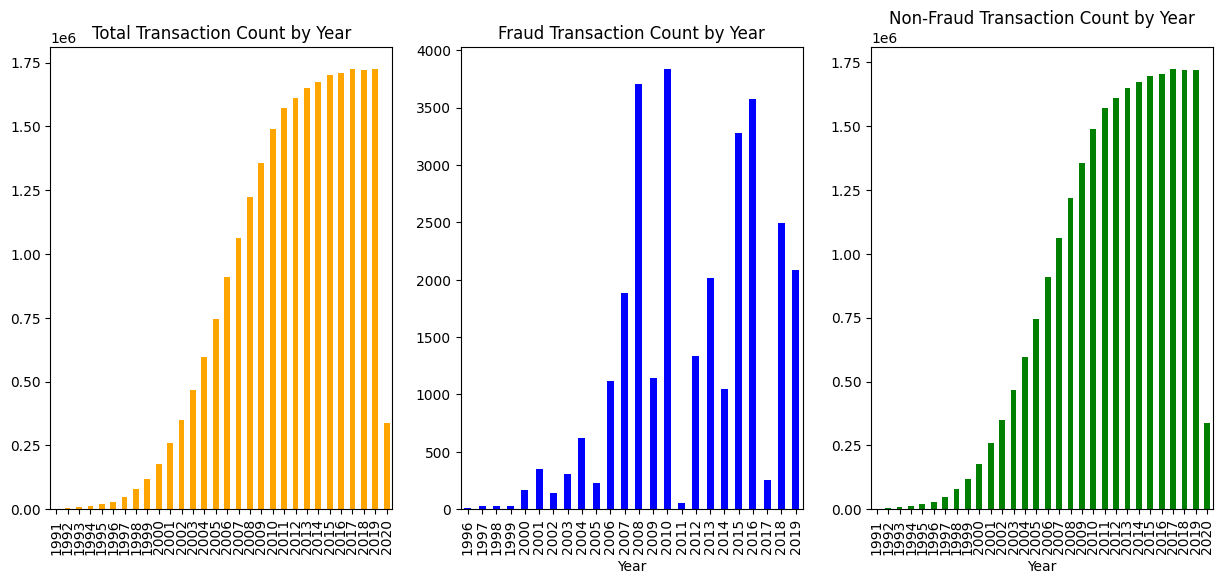

In [27]:
plt.figure(figsize=(15, 6))

# Total Transactions by year
plt.subplot(1, 3, 1)
transactions_by_year = df_transactions['Year'].value_counts().sort_index()
transactions_by_year.plot(kind = 'bar', color = 'orange')
plt.title('Total Transaction Count by Year')

# fraud transactions by year
plt.subplot(1, 3, 2)
fraud_transactions_by_year = df_transactions[df_transactions['Is Fraud?'] == 1].groupby(by = 'Year')['Is Fraud?'].count()
fraud_transactions_by_year.plot(kind = 'bar', color = 'blue')
plt.title('Fraud Transaction Count by Year')

# non-fraud transactions by year
plt.subplot(1, 3, 3)
nonfraud_transactions_by_year = df_transactions[df_transactions['Is Fraud?'] == 0].groupby(by = 'Year')['Is Fraud?'].count()
nonfraud_transactions_by_year.plot(kind = 'bar', color = 'green')
plt.title('Non-Fraud Transaction Count by Year')

We can see that entering the 21st century, the number of fraud cases has been steadily rising year by year, reaching its peak in 2007-2008 during the Great Recession.

#### Transactions by Month

Text(0.5, 1.0, 'Non-Fraud Transaction Count by Month')

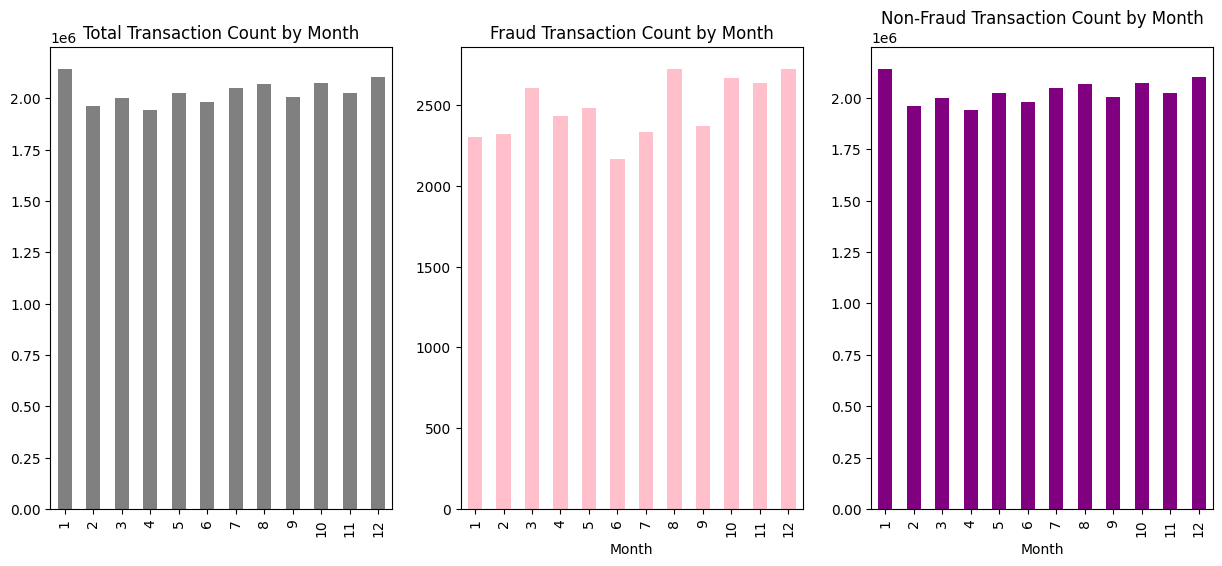

In [28]:
plt.figure(figsize=(15, 6))

# Total Transactions by month
plt.subplot(1, 3, 1)
transactions_by_month = df_transactions['Month'].value_counts().sort_index()
transactions_by_month.plot(kind = 'bar', color = 'gray')
plt.title('Total Transaction Count by Month')

# fraud transactions by month
plt.subplot(1, 3, 2)
fraud_transactions_by_month = df_transactions[df_transactions['Is Fraud?'] == 1].groupby(by = 'Month')['Is Fraud?'].count()
fraud_transactions_by_month.plot(kind = 'bar', color = 'pink')
plt.title('Fraud Transaction Count by Month')

# non-fraud transactions by month
plt.subplot(1, 3, 3)
nonfraud_transactions_by_month = df_transactions[df_transactions['Is Fraud?'] == 0].groupby(by = 'Month')['Is Fraud?'].count()
nonfraud_transactions_by_month.plot(kind = 'bar', color = 'purple')
plt.title('Non-Fraud Transaction Count by Month')

#### Transactions by Day of the Month

Text(0.5, 1.0, 'Non-Fraud Transaction Count by Day of the Month')

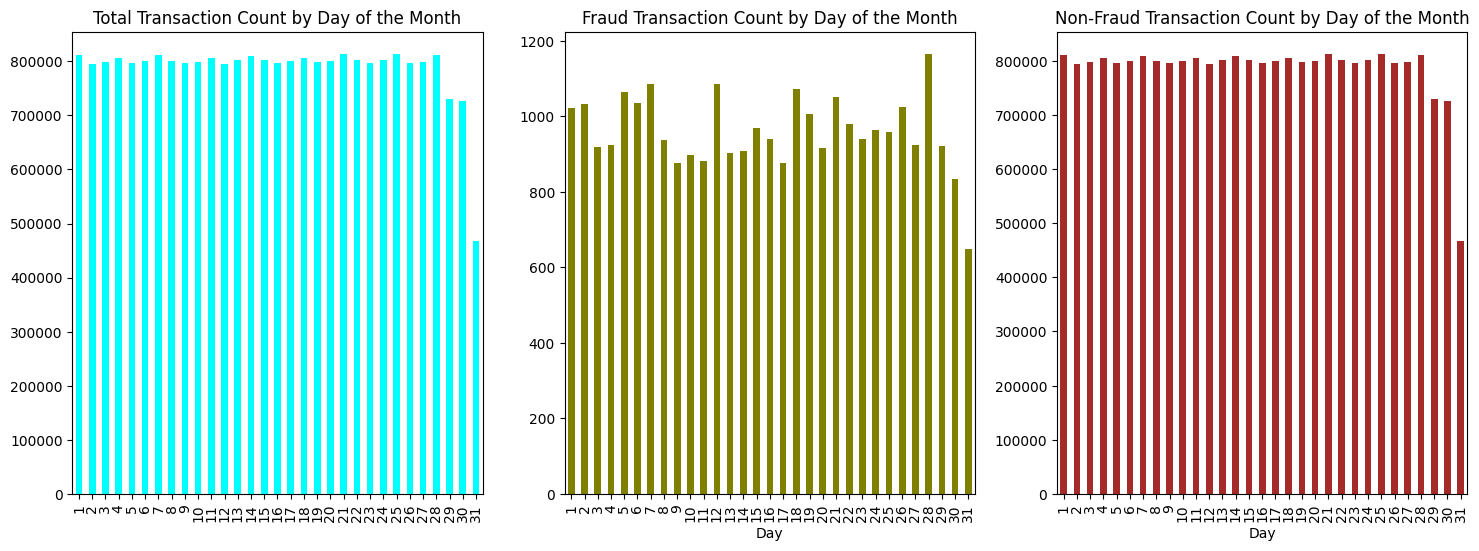

In [29]:
plt.figure(figsize=(18, 6))

# Total Transactions by day of the month
plt.subplot(1, 3, 1)
transactions_by_day = df_transactions['Day'].value_counts().sort_index()
transactions_by_day.plot(kind = 'bar', color = 'cyan')
plt.title('Total Transaction Count by Day of the Month')

# fraud transactions by day of the month
plt.subplot(1, 3, 2)
fraud_transactions_by_day = df_transactions[df_transactions['Is Fraud?'] == 1].groupby(by = 'Day')['Is Fraud?'].count()
fraud_transactions_by_day.plot(kind = 'bar', color = 'olive')
plt.title('Fraud Transaction Count by Day of the Month')

# non-fraud transactions by day of the month
plt.subplot(1, 3, 3)
nonfraud_transactions_by_day = df_transactions[df_transactions['Is Fraud?'] == 0].groupby(by = 'Day')['Is Fraud?'].count()
nonfraud_transactions_by_day.plot(kind = 'bar', color = 'brown')
plt.title('Non-Fraud Transaction Count by Day of the Month')

#### Distribution of Fraud vs. Non-Fraud Transactions

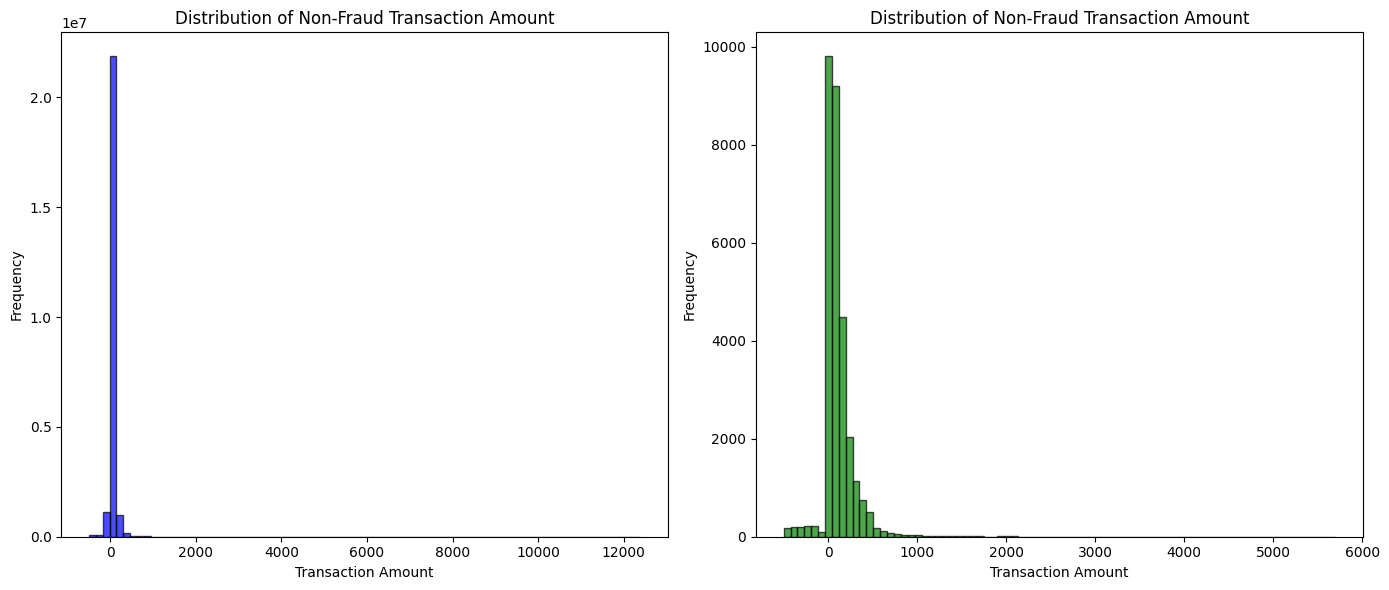

In [30]:
# histogram of non-fraud transactions
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(df_transactions[df_transactions['Is Fraud?'] == 0]['Amount'], bins=80, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Non-Fraud Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# histogram for fraud transactions
plt.subplot(1, 2, 2)
plt.hist(df_transactions[df_transactions['Is Fraud?'] == 1]['Amount'], bins=80, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of Non-Fraud Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Fraud rate by transaction "use chip" type

In [31]:
# Group by "Use Chip" and "Is Fraud?" and count the number of transactions
fraud_counts = df_transactions.groupby(['Use Chip', 'Is Fraud?']).size().unstack(fill_value=0)
fraud_counts

Is Fraud?,0,1
Use Chip,,
Chip Transaction,6282762,4836
Online Transaction,2694871,18349
Swipe Transaction,15379510,6572


In [32]:
fraud_counts = fraud_counts.reset_index()

In [33]:
# Calculate the percentage of fraudulent transactions for each transaction type
fraud_counts['Fraud Percentage'] = (fraud_counts[1] / (fraud_counts[0] + fraud_counts[1])) * 100
fraud_counts.reset_index()

Is Fraud?,index,Use Chip,0,1,Fraud Percentage
0,0,Chip Transaction,6282762,4836,0.076913
1,1,Online Transaction,2694871,18349,0.676281
2,2,Swipe Transaction,15379510,6572,0.042714


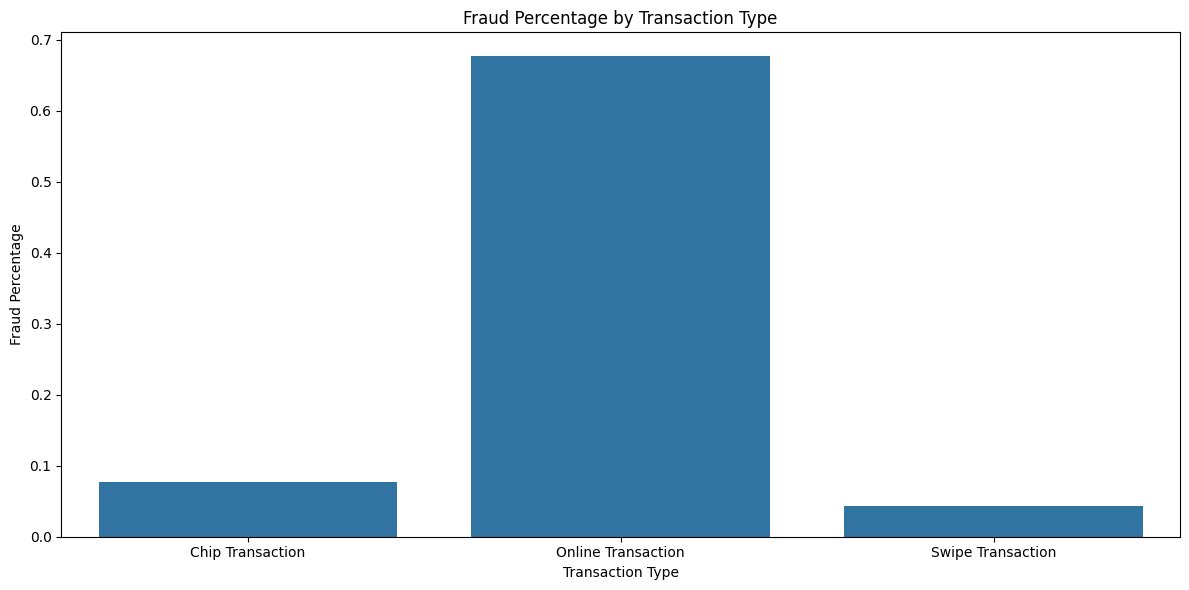

In [34]:
# plot the fraud rate by type
plt.figure(figsize=(12, 6))
sns.barplot(x = 'Use Chip', y = 'Fraud Percentage', data = fraud_counts.reset_index())
plt.title('Fraud Percentage by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Percentage')
plt.tight_layout()
plt.show()

It appeared that online transactions experienced the highest fraud rate of 0.68% compared to 0.08% fraud rate from chip transactions and 0.04% fraud rate with swipe transactions.

#### Transactions by State

In [35]:
# transaction count by state
pd.DataFrame({'Merchant State': df_transactions['Merchant State'].unique()})

,Merchant State
0,CA
1,NaN
2,NE
3,IL
4,MO
...,...
219,Central African Republic
220,Qatar
221,East Timor (Timor-Leste)
222,Seychelles


It appeared that the 'Merchant State' column contains both US states as well as other countries. For non-US countries, their Zip column only shows '0.0', only US states have Zipcode information.

In [36]:
df_transactions[df_transactions['Merchant State'] == 'United Kingdom']['Zip'].unique()

array([0.])

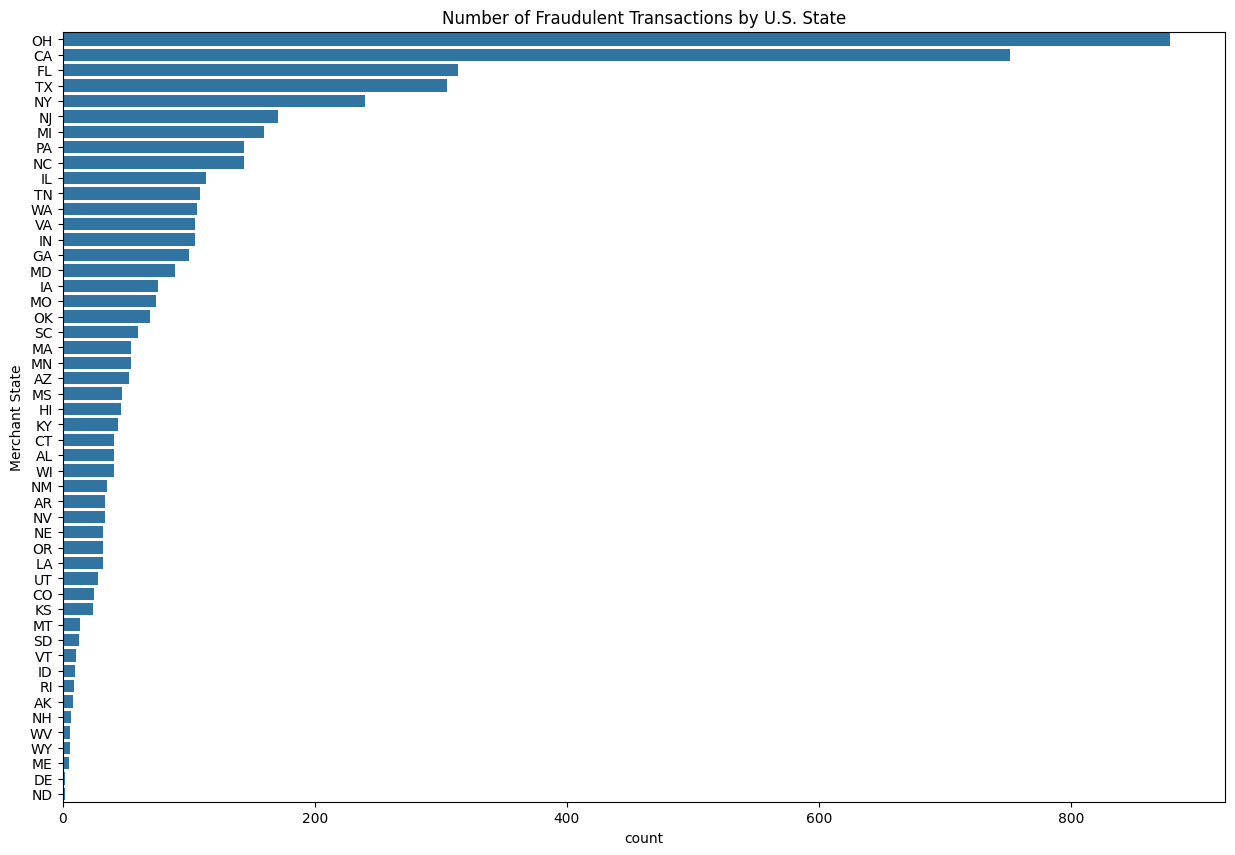

In [37]:
# fraud transactions by US States
us_fraud_transactions = df_transactions[(df_transactions['Zip'] != 0) & (df_transactions['Is Fraud?'] == 1)]

plt.figure(figsize=(15, 10))
sns.countplot(data = us_fraud_transactions,
              y = 'Merchant State',
              order = us_fraud_transactions['Merchant State'].value_counts().index)
plt.title('Number of Fraudulent Transactions by U.S. State')
plt.show()

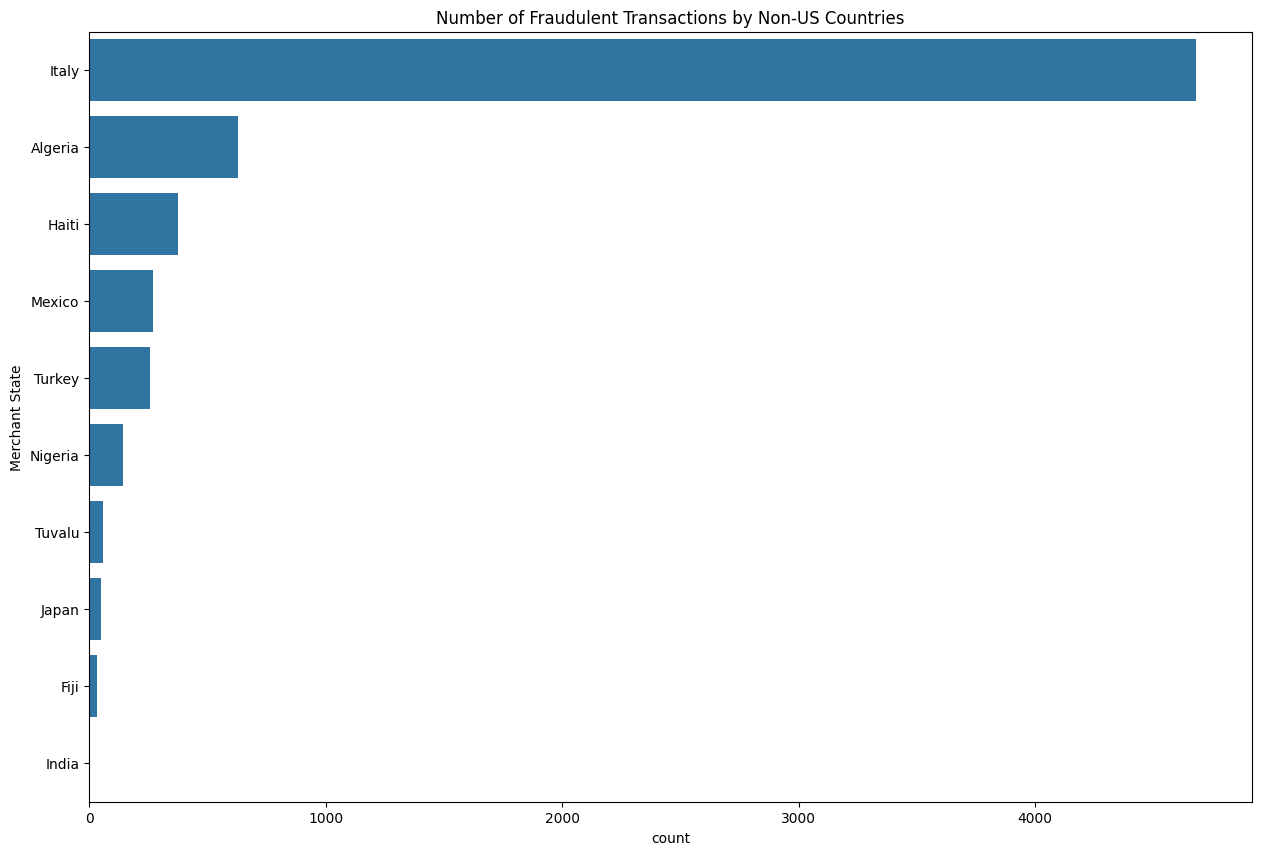

In [38]:
# fraud transactions by Non-US Countries
non_us_fraud_transactions = df_transactions[(df_transactions['Zip'] == 0) & (df_transactions['Is Fraud?'] == 1)]

plt.figure(figsize=(15, 10))
sns.countplot(data = non_us_fraud_transactions,
              y = 'Merchant State',
              order = non_us_fraud_transactions['Merchant State'].value_counts().index)
plt.title('Number of Fraudulent Transactions by Non-US Countries')
plt.show()

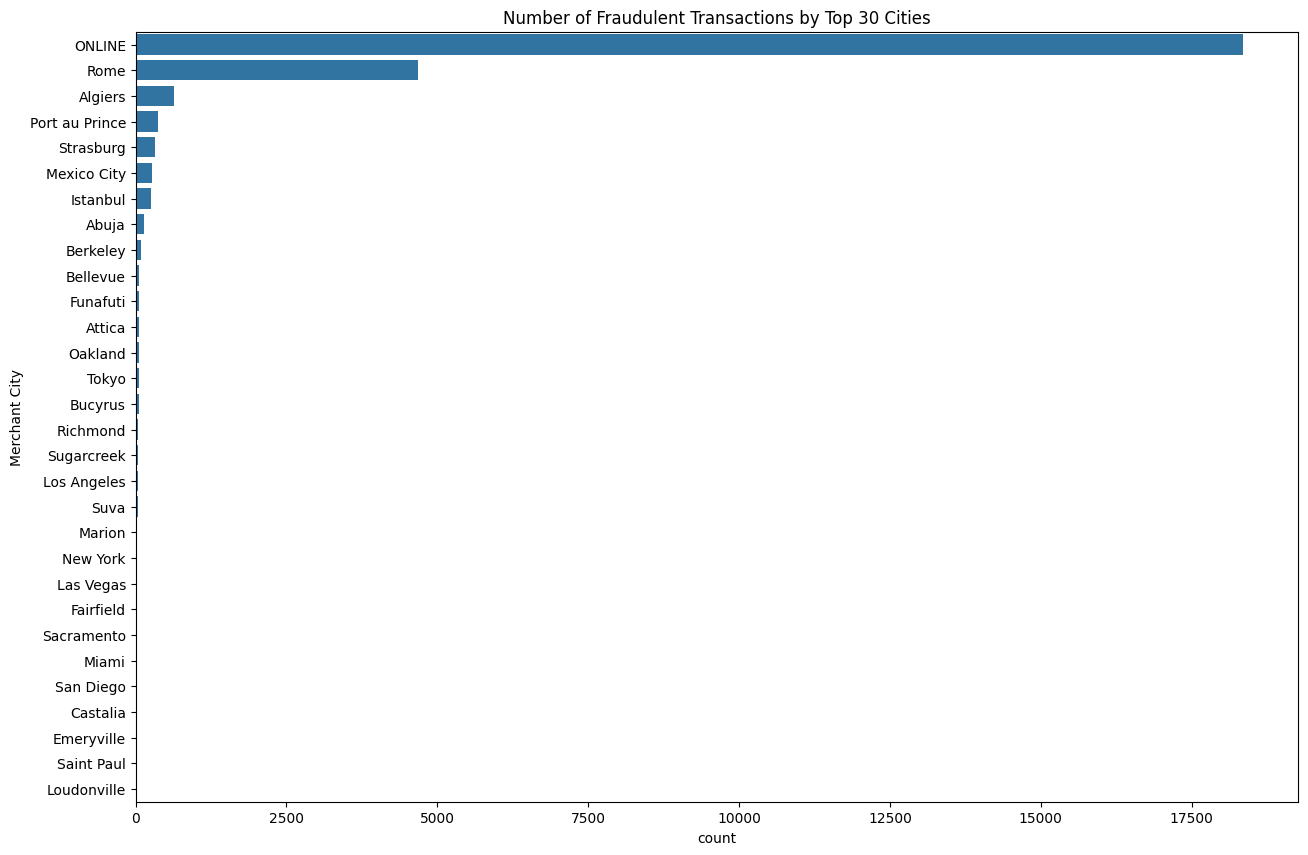

In [39]:
# fraud transactions by Major Cities
plt.figure(figsize=(15, 10))
top_cities = df_transactions[(df_transactions['Is Fraud?'] == 1)]['Merchant City'].value_counts().head(30).index
sns.countplot(data = df_transactions[(df_transactions['Is Fraud?'] == 1)],
              y = 'Merchant City',
              order = top_cities)
plt.title('Number of Fraudulent Transactions by Top 30 Cities')
plt.show()

#### Key observations
* At the country level, Italy, Algeria, Haiti, and Mexico are the major hotspot for fraudulent activities.
* Among US states, Ohio, California, and Florida records the highest incidences of fraud.
* Online transactions are the primary venues where fraud predominantly occurs. Additionally, cities such as Rome, Algiers, and Port-au-Prince are notable hotspots for high frequencies of fraudulent activities.

## Question 1: Merchant Spending Analysis
Plot a time series depicting daily and cumulative spending at the top 5 merchants. Define the criteria for "largest" merchants.

In [40]:
# Combine Year, Month, Day into a single datetime column for plotting
df_transactions['Date'] = pd.to_datetime(df_transactions[['Year', 'Month', 'Day']])
df_transactions['Date'].unique()

array(['2002-09-01T00:00:00.000000000', '2002-09-02T00:00:00.000000000',
       '2002-09-03T00:00:00.000000000', ...,
       '1991-11-19T00:00:00.000000000', '1991-11-27T00:00:00.000000000',
       '1991-11-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [41]:
# Extract the hour from the Time column
df_transactions['Hour'] = df_transactions['Time'].apply(lambda x: int(x.split(":")[0]))
df_transactions['Hour'].unique()

array([ 6, 17, 13,  5,  9, 20, 22, 21, 19, 11, 14,  8, 12, 10, 18, 16,  7,
       23,  3, 15,  0,  1,  2,  4])

### By Transaction Count; Same Merchants Over Time
Definition: Here we define top 5 merchants as the merchants that recorded the highest transaction count for the entire time frame of the data, meaning the specific merchants ranked top 5 will be fixed over time.

#### total daily spending

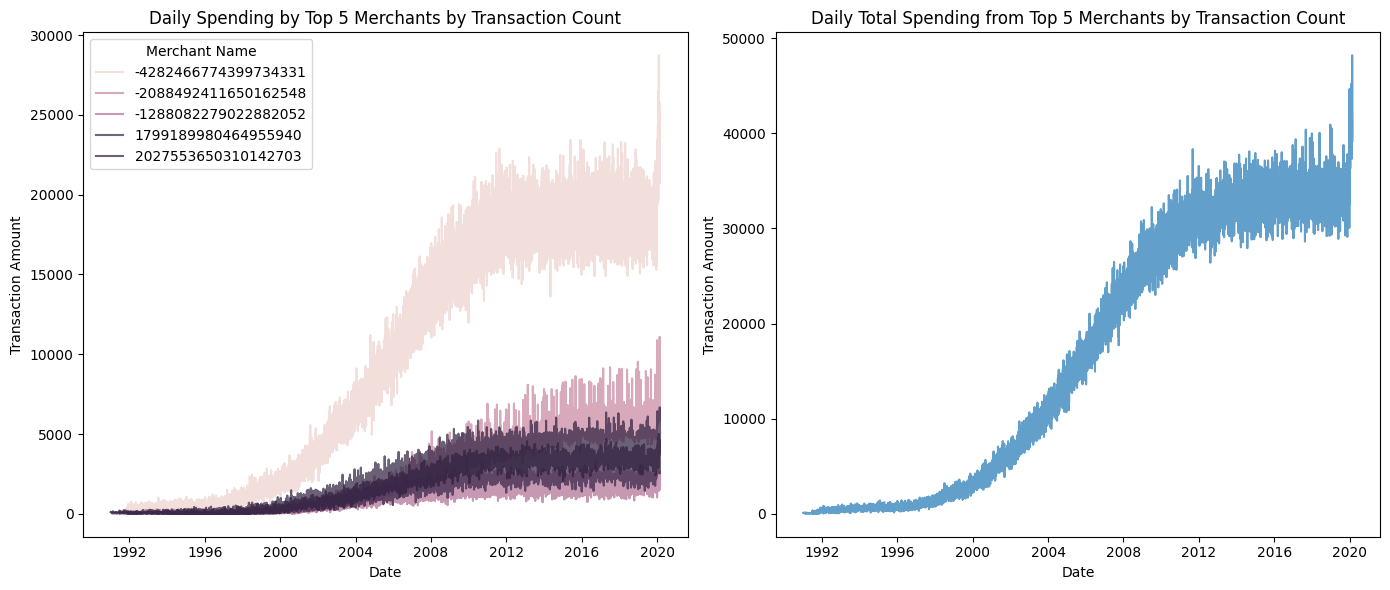

In [42]:
# total daily spending

# find the top 5 merchants based on definition
top5_merchants_bycount = df_transactions.groupby('Merchant Name')['Is Fraud?'].count().nlargest(5).index

# filter transactions just from the top 5 merchants
transact_top5_merchants_bycount = df_transactions[df_transactions['Merchant Name'].isin(top5_merchants_bycount)]

# plot five merchants in individual lines
top5_merch_daily_spending = transact_top5_merchants_bycount.groupby(['Merchant Name', 'Date'])['Amount'].sum().reset_index()

# plot five merchants' total spending in one combined line
top5_merch_daily_spending_sum = transact_top5_merchants_bycount.groupby(['Date'])['Amount'].sum().reset_index()


plt.figure(figsize=(14, 6))
# plot five merchants in individual lines
plt.subplot(1, 2, 1)
sns.lineplot(data = top5_merch_daily_spending,
             x = 'Date',
             y = 'Amount',
             hue = 'Merchant Name',
             alpha=0.7)
plt.title('Daily Spending by Top 5 Merchants by Transaction Count')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

# plot five merchants' total spending in one combined line
plt.subplot(1, 2, 2)
sns.lineplot(data = top5_merch_daily_spending_sum,
             x = 'Date',
             y = 'Amount',
             alpha=0.7)
plt.title('Daily Total Spending from Top 5 Merchants by Transaction Count')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

plt.tight_layout()
plt.show()


#### total cumulative spending

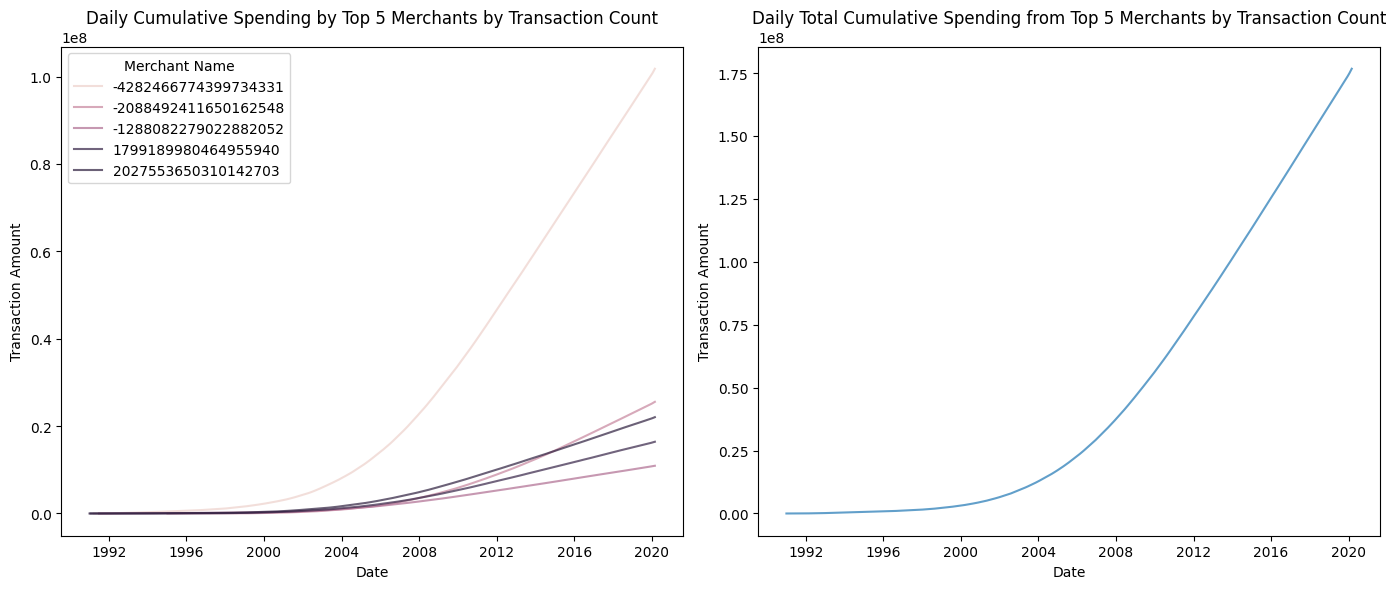

In [43]:
# total cumulative spending

# plot five merchants in individual lines
top5_merch_daily_spending.sort_values(by = ['Merchant Name', 'Date'], inplace = True)
top5_merch_daily_spending['cumsum'] = top5_merch_daily_spending.groupby(['Merchant Name'])['Amount'].cumsum()

# plot five merchants in one combined line
top5_merch_daily_spending_sum.sort_values(by = ['Date'], inplace = True)
top5_merch_daily_spending_sum['cumsum'] = top5_merch_daily_spending_sum['Amount'].cumsum()

# plot
plt.figure(figsize=(14, 6))
# plot five merchants in individual lines
plt.subplot(1, 2, 1)
sns.lineplot(data = top5_merch_daily_spending,
             x = 'Date',
             y = 'cumsum',
             hue = 'Merchant Name',
             alpha = 0.7)
plt.title('Daily Cumulative Spending by Top 5 Merchants by Transaction Count')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

# plot five merchants' total spending in one combined line
plt.subplot(1, 2, 2)
sns.lineplot(data = top5_merch_daily_spending_sum,
             x = 'Date',
             y = 'cumsum',
             alpha=0.7)
plt.title('Daily Total Cumulative Spending from Top 5 Merchants by Transaction Count')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

plt.tight_layout()
plt.show()

### By Transaction Count; Different Merchants Daily
Definition: Here we define top 5 merchants as the merchants that recorded the highest transaction count every day, meaning the specific merchants may vary daily based on the transaction count.

#### total daily spending
Due to the fact that the top 5 merchants will likely be different every day, here we only plot a combined single line to represent the total daily spending for the top 5 merchants, instead of plotting the top 5 merchants individually.

Text(0, 0.5, 'Transaction Amount')

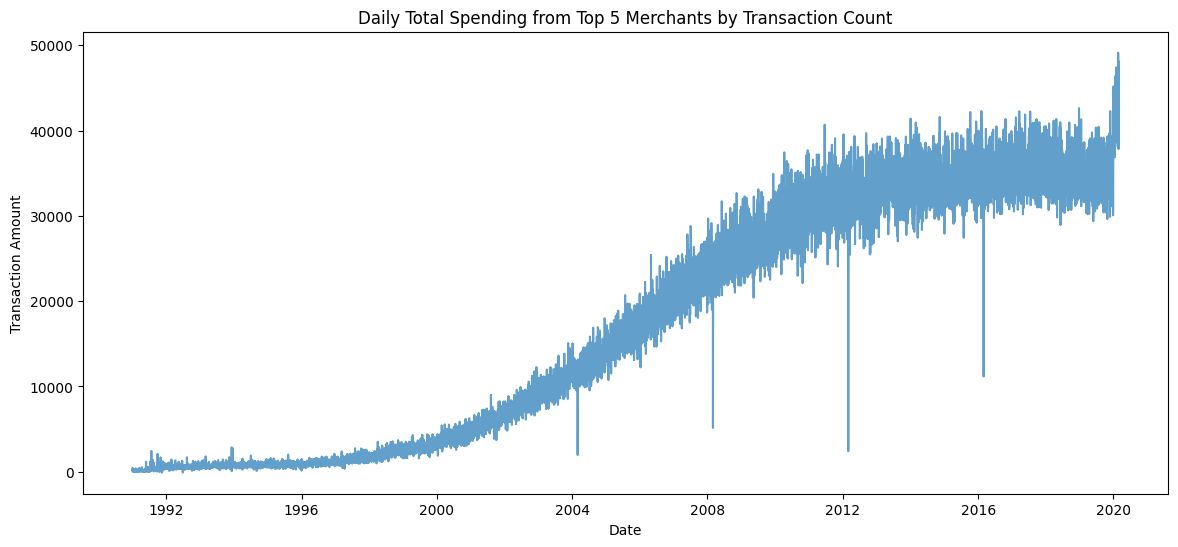

In [44]:
# total daily spending

# Step 1: Calculate daily spending per merchant
daily_transactions_by_merchant = df_transactions.groupby(['Date', 'Merchant Name']).agg(
    Daily_Transaction_Count = ('Is Fraud?', 'count'),
    Daily_Spending = ('Amount', 'sum')).reset_index()

# Step 2 & 3: For each day, find the top 5 merchants by spending and sum their spending
def get_top_5_merchants_by_count(group):
    return group.nlargest(5, 'Daily_Transaction_Count')

daily_varied_top5_spending = daily_transactions_by_merchant.groupby('Date').apply(get_top_5_merchants_by_count).reset_index(drop=True)

# calculate the daily sum spending for top5 merchants
daily_varied_top5_spending_sum = daily_varied_top5_spending.groupby('Date')['Daily_Spending'].sum().reset_index()

# Plotting the total daily spending from the top 5 merchants
plt.figure(figsize=(14, 6))
# plot five merchants in one combined line
sns.lineplot(data = daily_varied_top5_spending_sum,
             x = 'Date',
             y = 'Daily_Spending',
             alpha=0.7)
plt.title('Daily Total Spending from Top 5 Merchants by Transaction Count')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

Text(0, 0.5, 'Transaction Amount')

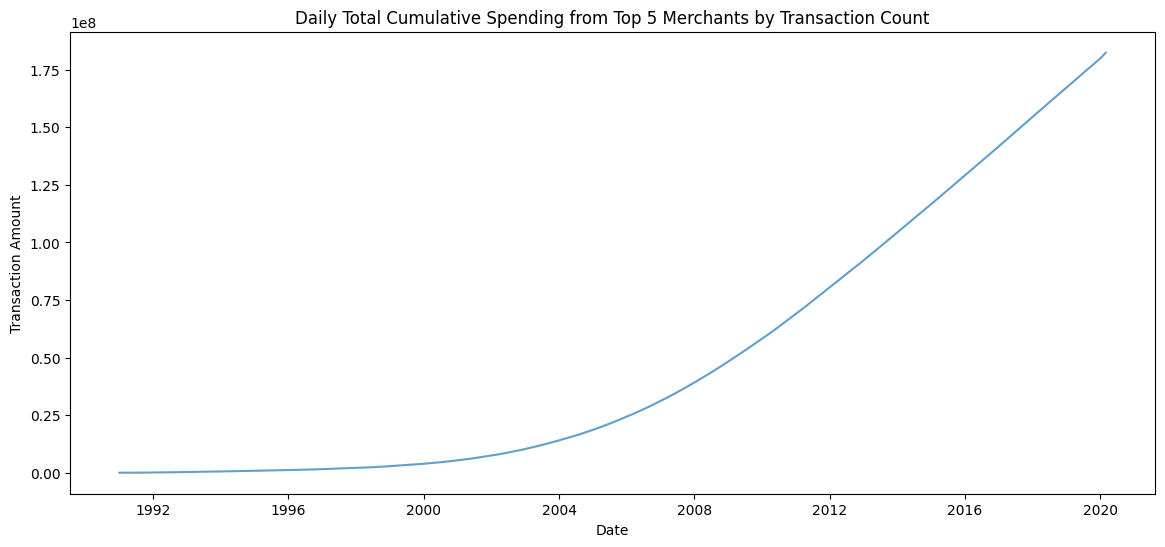

In [45]:
# total cumulative spending
daily_varied_top5_spending_sum['cumsum'] = daily_varied_top5_spending_sum['Daily_Spending'].cumsum()

# plot
plt.figure(figsize=(14, 6))
# plot five merchants in one combined line
sns.lineplot(data = daily_varied_top5_spending_sum,
             x = 'Date',
             y = 'cumsum',
             alpha=0.7)
plt.title('Daily Total Cumulative Spending from Top 5 Merchants by Transaction Count')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

### By Transaction Amount; Same Merchants Over Time
Definition: Here we define top 5 merchants as the merchants that recorded the highest transaction dollar amount for the entire time frame of the data, meaning the specific merchants ranked top 5 will be fixed over time.

#### total daily spending

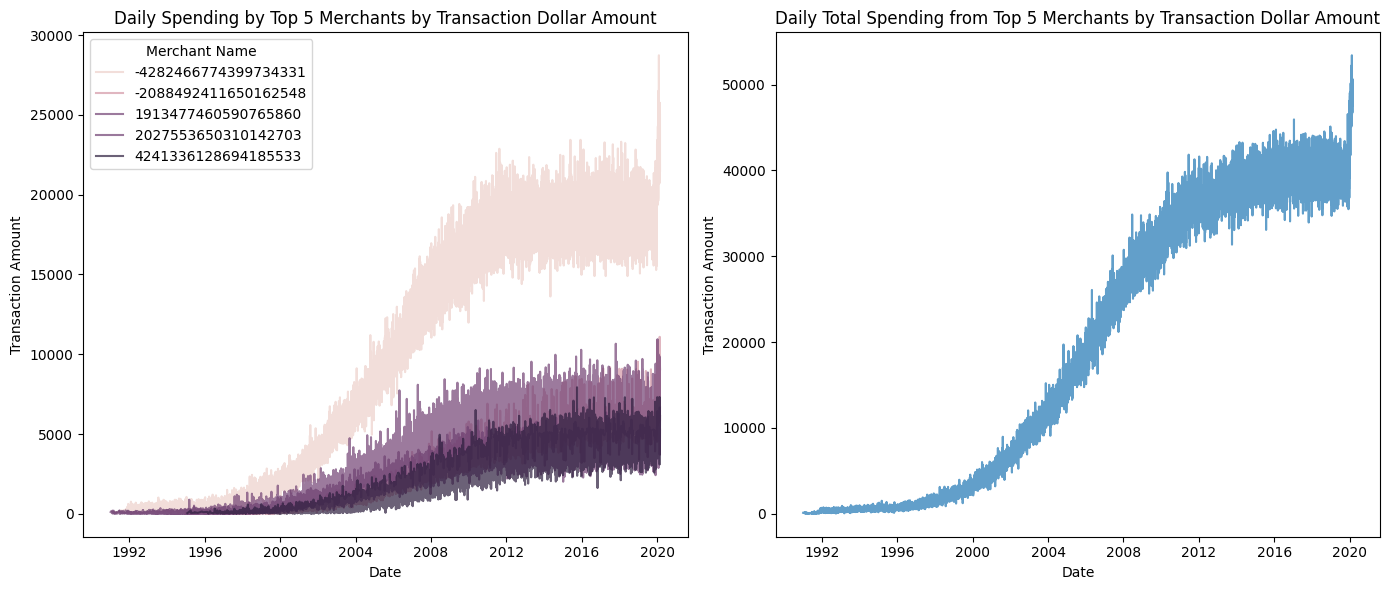

In [46]:
# find the top 5 merchants based on definition
top5_merchants_byvalue = df_transactions.groupby('Merchant Name')['Amount'].sum().nlargest(5).index

# filter transactions just from the top 5 merchants
transact_top5_merchants_byvalue = df_transactions[df_transactions['Merchant Name'].isin(top5_merchants_byvalue)]

# plot five merchants in individual lines
top5_merch_daily_spending_byvalue = transact_top5_merchants_byvalue.groupby(['Merchant Name', 'Date'])['Amount'].sum().reset_index()

# plot five merchants' total spending in one combined line
top5_merch_daily_spending_byvalue_sum = top5_merch_daily_spending_byvalue.groupby(['Date'])['Amount'].sum().reset_index()


plt.figure(figsize=(14, 6))
# plot five merchants in individual lines
plt.subplot(1, 2, 1)
sns.lineplot(data = top5_merch_daily_spending_byvalue,
             x = 'Date',
             y = 'Amount',
             hue = 'Merchant Name',
             alpha=0.7)
plt.title('Daily Spending by Top 5 Merchants by Transaction Dollar Amount')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

# plot five merchants' total spending in one combined line
plt.subplot(1, 2, 2)
sns.lineplot(data = top5_merch_daily_spending_byvalue_sum,
             x = 'Date',
             y = 'Amount',
             alpha=0.7)
plt.title('Daily Total Spending from Top 5 Merchants by Transaction Dollar Amount')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

plt.tight_layout()
plt.show()

#### total cumulative spending

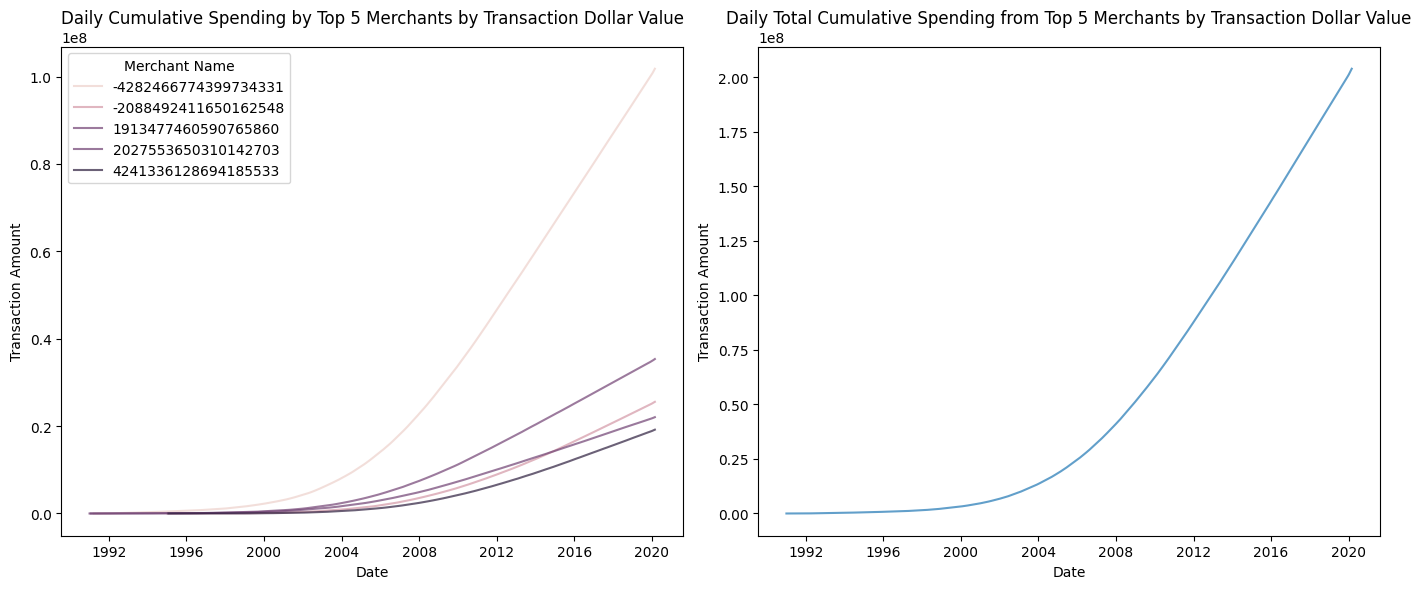

In [47]:
# plot five merchants in individual lines
top5_merch_daily_spending_byvalue.sort_values(by = ['Merchant Name', 'Date'], inplace = True)
top5_merch_daily_spending_byvalue['cumsum'] = top5_merch_daily_spending_byvalue.groupby(['Merchant Name'])['Amount'].cumsum()

# plot five merchants in one combined line
top5_merch_daily_spending_byvalue_sum.sort_values(by = ['Date'], inplace = True)
top5_merch_daily_spending_byvalue_sum['cumsum'] = top5_merch_daily_spending_byvalue_sum['Amount'].cumsum()

# plot
plt.figure(figsize=(14, 6))
# plot five merchants in individual lines
plt.subplot(1, 2, 1)
sns.lineplot(data = top5_merch_daily_spending_byvalue,
             x = 'Date',
             y = 'cumsum',
             hue = 'Merchant Name',
             alpha = 0.7)
plt.title('Daily Cumulative Spending by Top 5 Merchants by Transaction Dollar Value')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

# plot five merchants' total spending in one combined line
plt.subplot(1, 2, 2)
sns.lineplot(data = top5_merch_daily_spending_byvalue_sum,
             x = 'Date',
             y = 'cumsum',
             alpha=0.7)
plt.title('Daily Total Cumulative Spending from Top 5 Merchants by Transaction Dollar Value')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

plt.tight_layout()
plt.show()

### By Transaction Amount; Different Merchants Daily
Definition: Here we define top 5 merchants as the merchants that recorded the highest transaction dollar amount each day, meaning the specific merchants may vary daily based on the transaction count.

#### total daily spending

Text(0, 0.5, 'Transaction Amount')

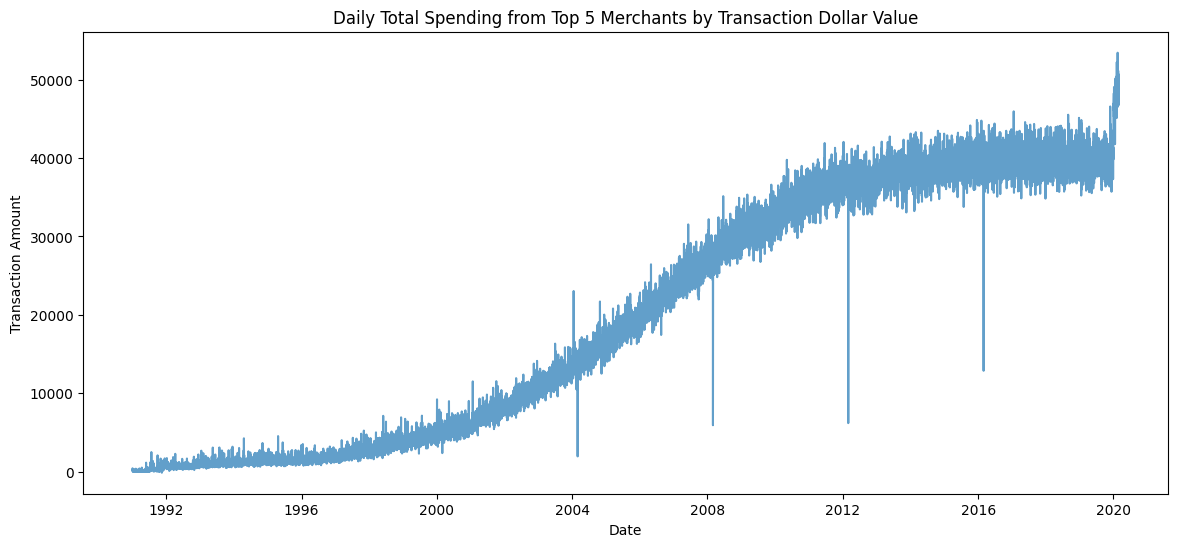

In [48]:
# Step 1: Calculate daily spending per merchant
daily_transactions_by_merchant = df_transactions.groupby(['Date', 'Merchant Name']).agg(
    Daily_Transaction_Count = ('Is Fraud?', 'count'),
    Daily_Spending = ('Amount', 'sum')).reset_index()

# Step 2 & 3: For each day, find the top 5 merchants by spending and sum their spending
def get_top_5_merchants_by_value(group):
    return group.nlargest(5, 'Daily_Spending')

daily_varied_top5_spending_byvalue = daily_transactions_by_merchant.groupby('Date').apply(get_top_5_merchants_by_value).reset_index(drop=True)

# calculate the daily sum spending for top5 merchants
daily_varied_top5_spending_sum_byvalue = daily_varied_top5_spending_byvalue.groupby('Date')['Daily_Spending'].sum().reset_index()

# Plotting the total daily spending from the top 5 merchants
plt.figure(figsize=(14, 6))
# plot five merchants in one combined line
sns.lineplot(data = daily_varied_top5_spending_sum_byvalue,
             x = 'Date',
             y = 'Daily_Spending',
             alpha=0.7)
plt.title('Daily Total Spending from Top 5 Merchants by Transaction Dollar Value')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

#### total cumulative spending

Text(0, 0.5, 'Transaction Amount')

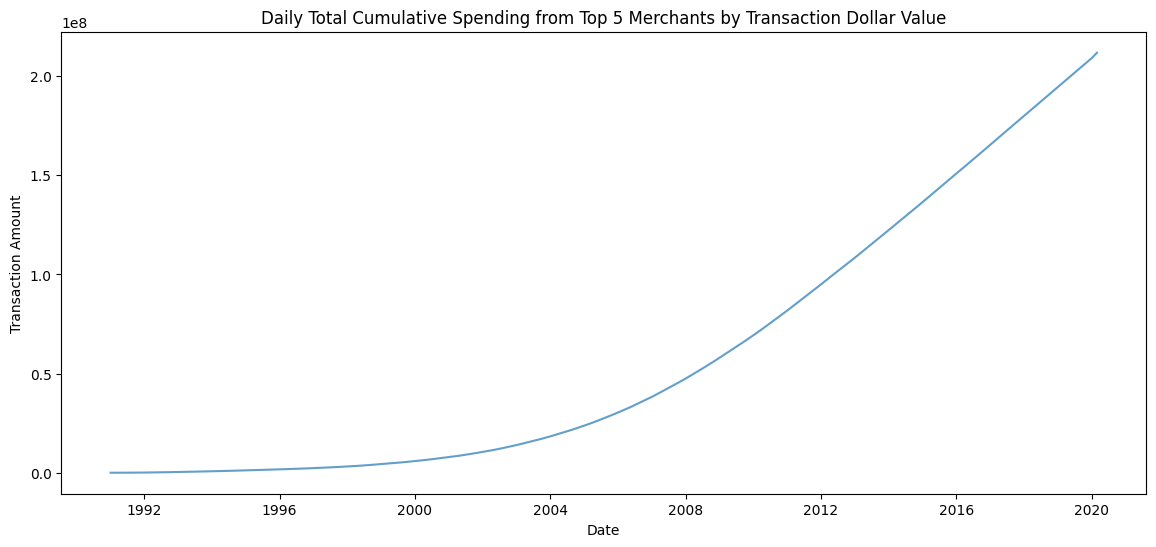

In [49]:
daily_varied_top5_spending_sum_byvalue['cumsum'] = daily_varied_top5_spending_sum_byvalue['Daily_Spending'].cumsum()

# plot
plt.figure(figsize=(14, 6))
# plot five merchants in one combined line
sns.lineplot(data = daily_varied_top5_spending_sum_byvalue,
             x = 'Date',
             y = 'cumsum',
             alpha=0.7)
plt.title('Daily Total Cumulative Spending from Top 5 Merchants by Transaction Dollar Value')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

## Question 2: Spending Patterns Analysis  
Investigate if certain days experience higher spending. Utilize visualizations and statistical methods to support your findings.

#### Average daily spending in time series

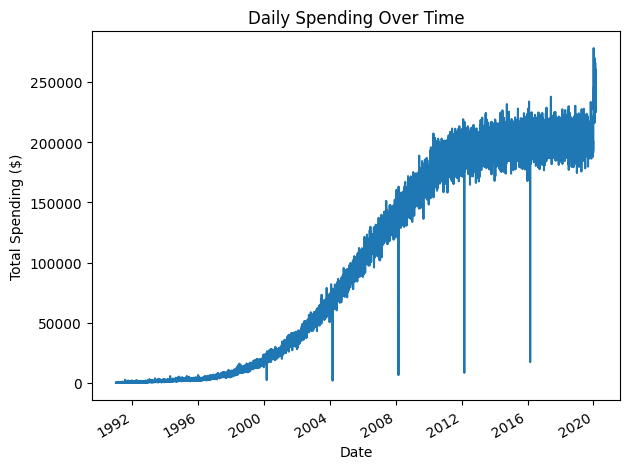

In [50]:
total_daily_spending = df_transactions.groupby('Date')['Amount'].sum()
total_daily_spending.plot()
plt.title('Daily Spending Over Time')
plt.xlabel('Date')
plt.ylabel('Total Spending ($)')
plt.tight_layout()
plt.show()

#### Boxplot showing distribution of daily spending

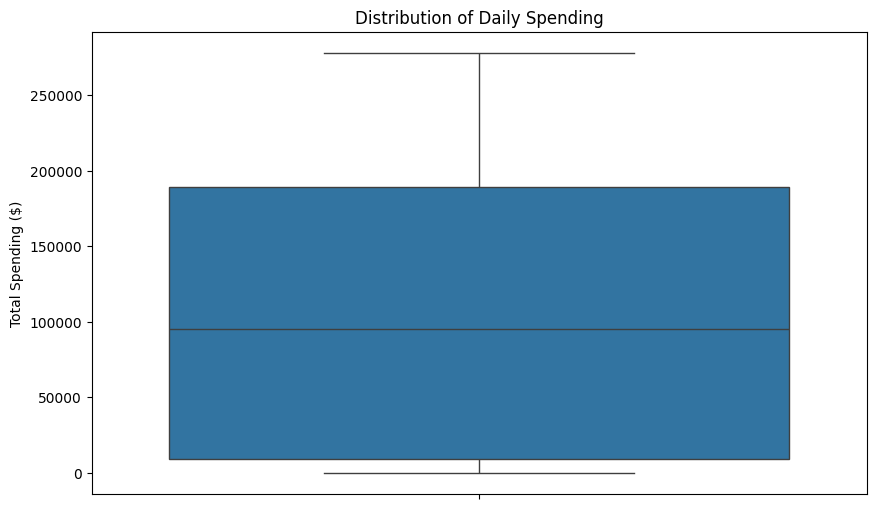

In [51]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=total_daily_spending)
plt.title('Distribution of Daily Spending')
plt.ylabel('Total Spending ($)')
plt.show()

It appeared that the vast majority of daily total spending was under USD200,000, therefore we may need to investigate the days where total daily spending exceeded USD200,000.

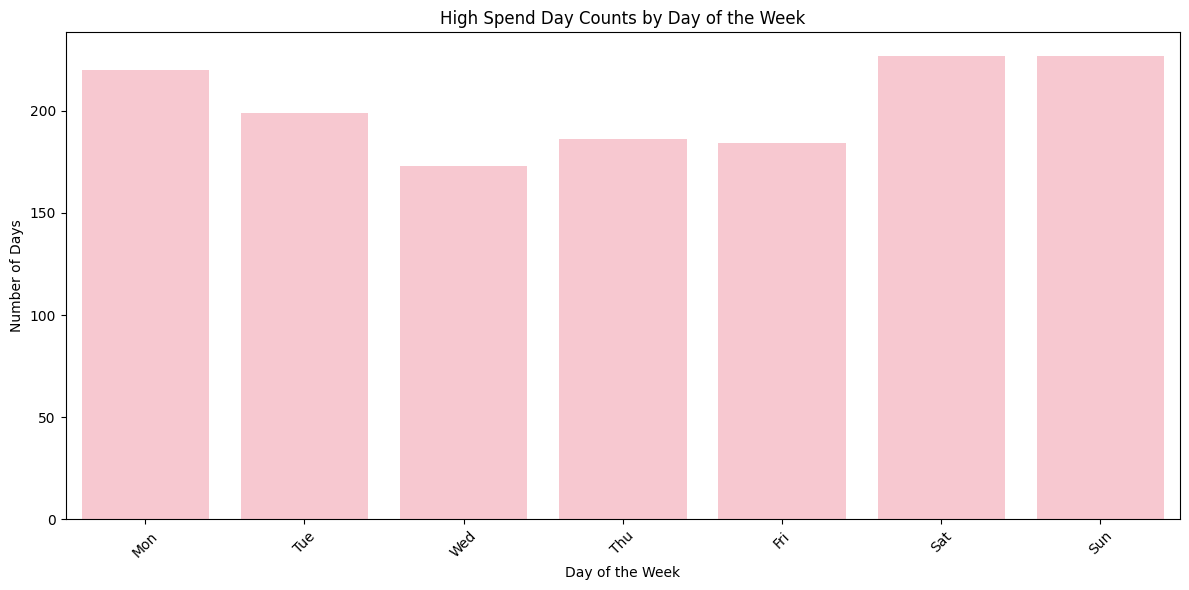

In [52]:
# get days of the week
days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df_total_daily_spending = pd.DataFrame(total_daily_spending).reset_index()
df_total_daily_spending['Day of Week'] = df_total_daily_spending['Date'].dt.dayofweek.map(days)

# get all the days where total spending exceeded upper bound threshold
q3 = df_total_daily_spending['Amount'].quantile(0.75)
q1 = df_total_daily_spending['Amount'].quantile(0.25)
upper_bound = min(q3 + (q3 - q1) * 1.5, 200000)
high_spend_days = df_total_daily_spending[df_total_daily_spending['Amount'] >= upper_bound]


# count high spending days of the week
df_high_spend_by_dayofweek = high_spend_days.groupby(by = 'Day of Week').agg(
    day_count = ('Date', 'count')
).reset_index()

# plot the high spend days by days of the week
plt.figure(figsize=(12, 6))
sns.barplot(x = 'Day of Week',
            y = 'day_count',
            color = 'pink',
           data = df_high_spend_by_dayofweek,
           order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('High Spend Day Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Days')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

It appeared that Sat, Sun, and Mon were generally experiencing total daily spending than the rest of the week.

#### By days of the month

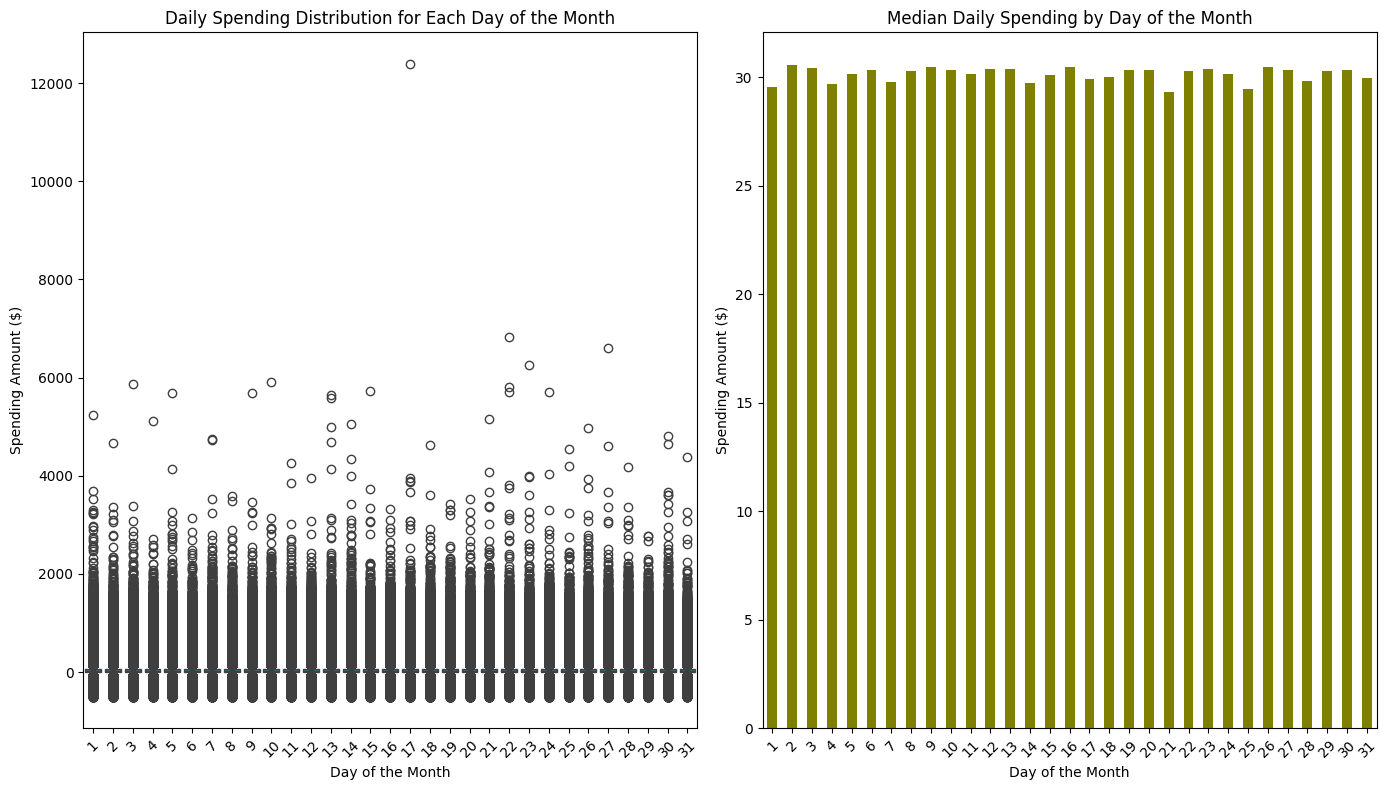

In [53]:
# first plot the total spending by day in the month
plt.figure(figsize=(14, 8))

# plot boxplot for each day of the month
plt.subplot(1, 2, 1)
sns.boxplot(
    x = 'Day',
    y = 'Amount',
    data = df_transactions)
plt.title('Daily Spending Distribution for Each Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Spending Amount ($)')
plt.xticks(rotation=45)

# plot median daily spending for each day of the month
median_daily_spending = df_transactions.groupby('Day')['Amount'].median()
plt.subplot(1, 2, 2)
median_daily_spending.plot(kind = 'bar', color = 'olive')
plt.title('Median Daily Spending by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Spending Amount ($)')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

#### By days of the week

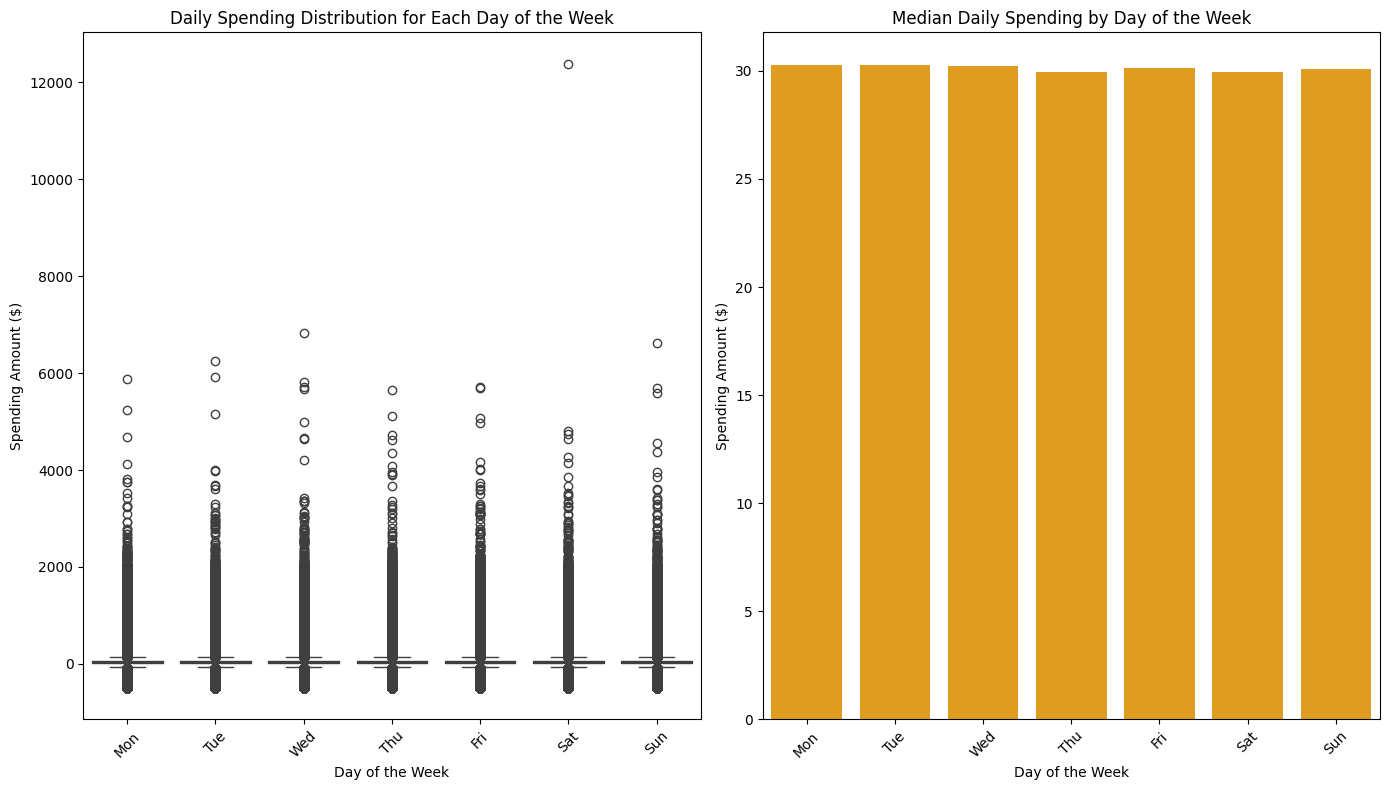

In [54]:
# find days of the week from the Date column
days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df_transactions['Day of Week'] = df_transactions['Date'].dt.dayofweek.map(days)

# plot the total spending by day in the week
plt.figure(figsize=(14, 8))

# plot boxplot for each day of the month
plt.subplot(1, 2, 1)
sns.boxplot(
    x = 'Day of Week',
    y = 'Amount',
    data = df_transactions,
    order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)
plt.title('Daily Spending Distribution for Each Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Spending Amount ($)')
plt.xticks(rotation=45)

# plot median daily spending for each day of the week
median_dayofweek_spending = df_transactions.groupby('Day of Week')['Amount'].median().reset_index()
plt.subplot(1, 2, 2)
sns.barplot(x = 'Day of Week',
            y = 'Amount',
            color = 'orange',
           data = median_dayofweek_spending,
           order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Median Daily Spending by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Spending Amount ($)')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

From above, we did see from the boxplots by day that Wed, Sat, Suns seemed to have more positive outliers compared to other days of the week. We can calculate IQR upper bound for each day of the week, and find out the days that are higher than the upper bound for each day of the week using  

$upperbound = Q3 + 1.5 * IQR$  

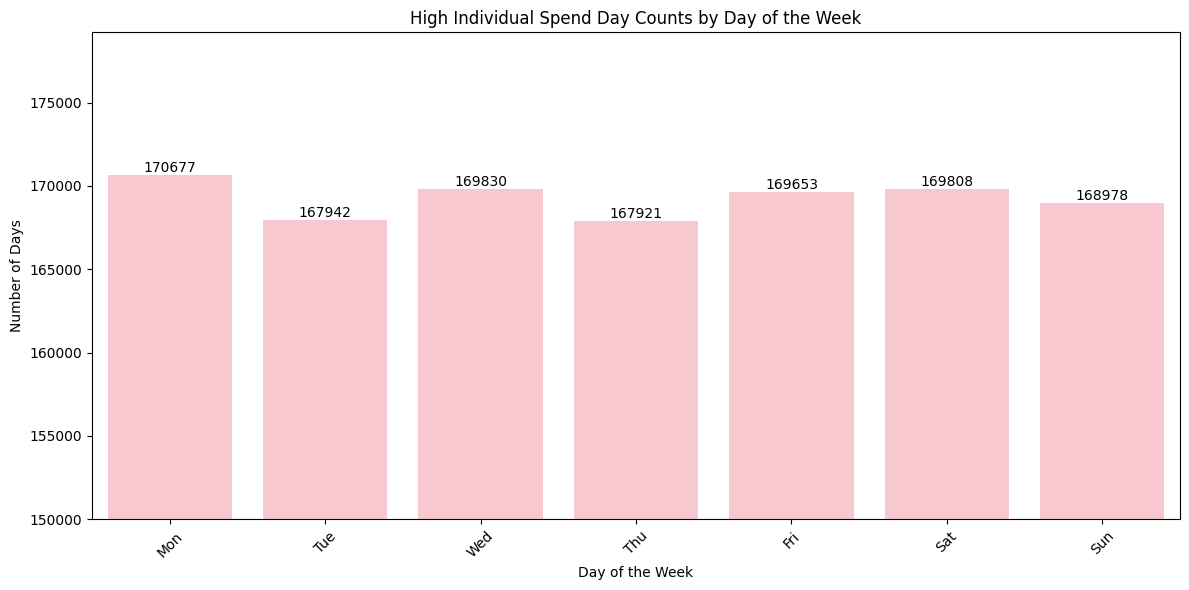

In [55]:
def filter_outliers_iqr(group):
    Q1 = group['Amount'].quantile(0.25)
    Q3 = group['Amount'].quantile(0.75)
    iqr = Q3 - Q1
    upper_bound = Q3 + 1.5 * iqr
    return group[group['Amount'] >= upper_bound]

# Apply the function to each group
higher_spending_transact = df_transactions.groupby(by = ['Day of Week']).apply(filter_outliers_iqr).reset_index(drop=True)

# Out of all the higher spend days, count the number of days by day of week
higher_spending_day_count = higher_spending_transact.groupby(by = 'Day of Week').agg(
    day_count = ('Date', 'count')
).reset_index()

# plot those day count
plt.figure(figsize=(12, 6))
ax = sns.barplot(x = 'Day of Week',
            y = 'day_count',
            color = 'pink',
           data = higher_spending_day_count,
           order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('High Individual Spend Day Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Days')
plt.ylim(ymin=150000)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

In [56]:
print(matplotlib.__version__)

3.7.1


If we look at the distribution of all the individual transactions and use IQR to set the upper bound of individual transation spending, we can see that Mon, Wed, and Sat were seeing higher number of days with higher individual spending transactions. However, based on the distribution of the daily spending, the higher than normal transactions were not extreme values or caused by data errors, those high spending transactions were fairly evenly distributed from USD1000 - USD6000 range, we don't see a need to specifically treat those higher spending data points.    

### Seasonal Decomposation
We can also use seasonal decomposation to break down the data into trends, seasonality, and randomness.

In [73]:
total_daily_spending_sd = pd.DataFrame(total_daily_spending).reset_index()
total_daily_spending_sd.set_index('Date', inplace=True)
total_daily_spending_sd = total_daily_spending_sd.asfreq('D')
total_daily_spending_sd_filled = total_daily_spending_sd.interpolate(method='linear')
total_daily_spending_sd_filled

,Amount
Date,
1991-01-02,228.350
1991-01-03,439.990
1991-01-04,43.630
1991-01-05,228.570
1991-01-06,123.495
...,...
2020-02-24,239531.250
2020-02-25,260166.720
2020-02-26,244752.970


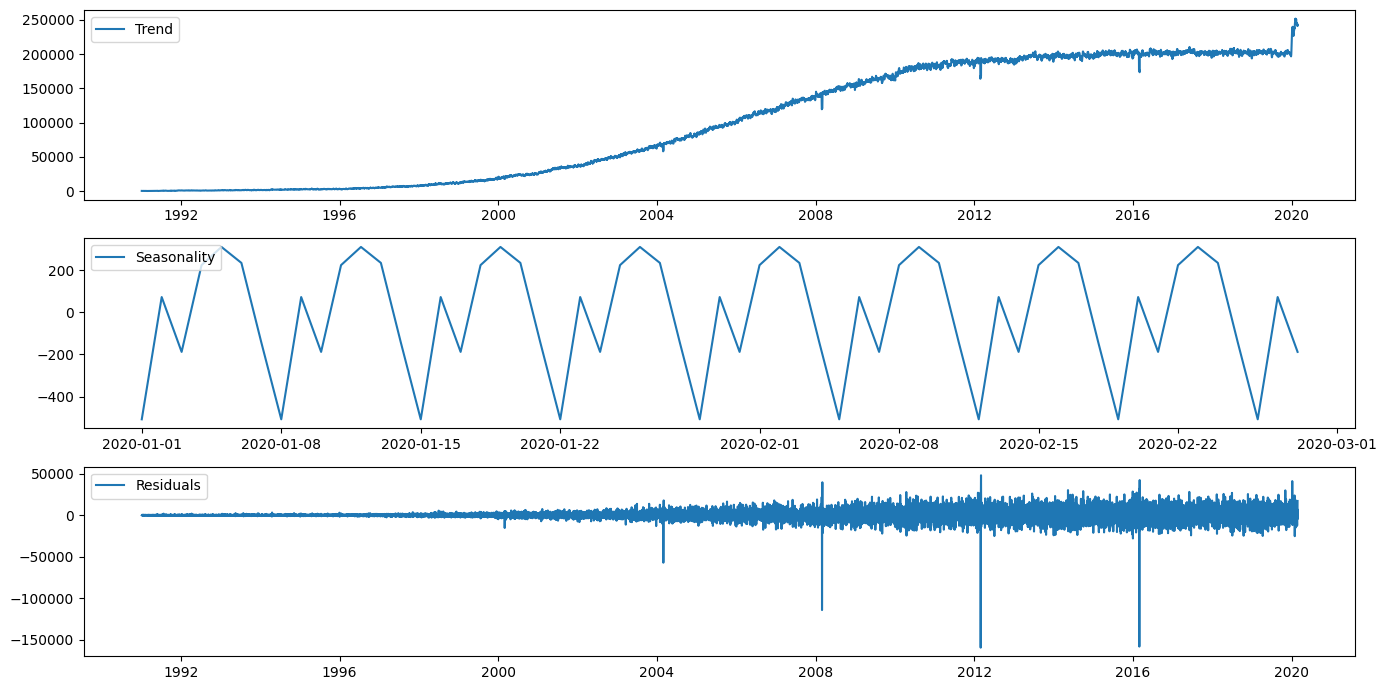

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform seasonal decomposition
decomposition = seasonal_decompose(total_daily_spending_sd_filled, model='additive')


# Plot the decomposed components
plt.figure(figsize=(14, 7))
plt.subplot(311)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(312)
plt.plot(decomposition.seasonal['2020'], label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(313)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

After running seasonal decomposition, by looking at only 1Q2023, we see clear same seasonal pattern every week, and if we look all years, it was the same pattern, with Sat, Sun, Mon spending significantly higher than the Tue, Wed, Thu. We see the same pattern for all weeks throughout the entire time frame, likely due to the fact that it is machine generated data, and the seasonality is algorithmically built in.

## Question 3: Bias Assessment in Dataset  
Analyze the dataset for potential biases. Describe any identified bias and explain how you determined its presence.

#### Detect data imbalance
We look at the fraud percentage over time, previously we already looked at fraud percentage by transaction type for the entire time frame, now we look at the fraud rate in time series.

In [80]:
df_transactions['Date'] = pd.to_datetime(df_transactions[['Year', 'Month', 'Day']])
daily_fraud_rate = df_transactions.groupby(['Date', 'Is Fraud?']).size().unstack(fill_value=0).reset_index()
daily_fraud_rate.rename(columns = {1: 'fraud', 0: 'no fraud'}, inplace = True)
daily_fraud_rate['Fraud Percentage'] = (daily_fraud_rate['fraud'] / (daily_fraud_rate['no fraud'] + daily_fraud_rate['fraud'])) * 100

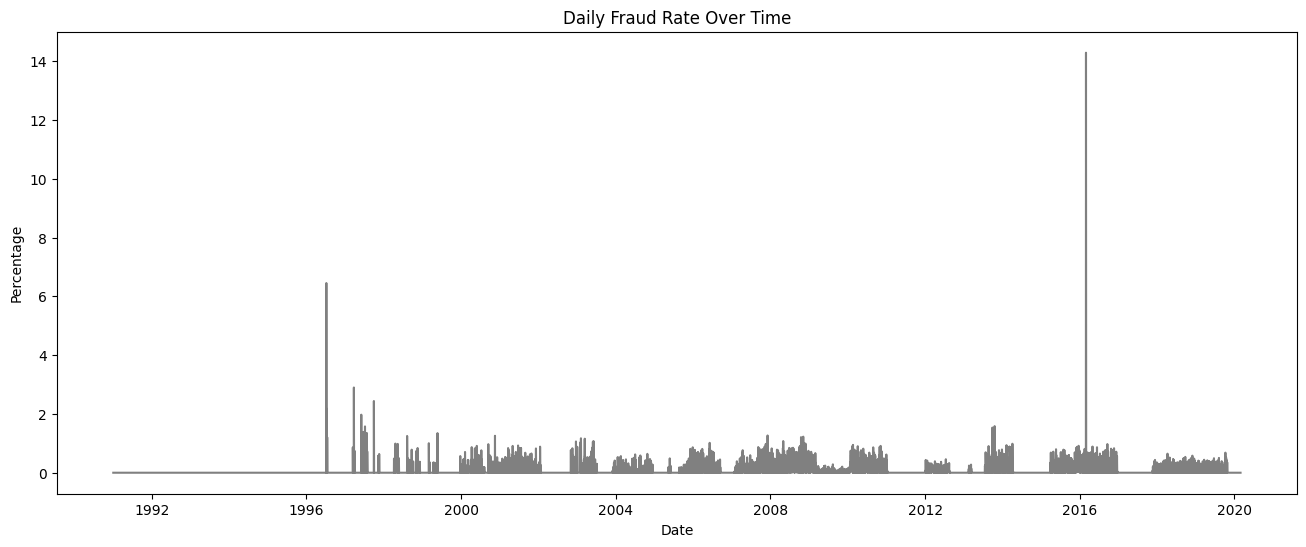

In [81]:
# plot daily fraud rate over time
plt.figure(figsize=(16, 6))
sns.lineplot(x = 'Date',
            y = 'Fraud Percentage',
            color = 'gray',
            data = daily_fraud_rate)
plt.title('Daily Fraud Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
# plt.ylim(ymax = 2)
plt.show()

We can see that with time series data, fraud rate varies daily but all below 2%, meaning vast majority 98%+ of the transactions were labeled as non-fraud, which introduced significant data imbalance issue. If untreated, this will likely cause several issues, including:  

* **Model Bias Towards Majority Class**: When one class dominates the dataset, machine learning models can become biased towards predicting the majority class. This happens because the model learns that the best strategy, in terms of overall accuracy, is to favor the class with more observations.  

* **Decreased Model Sensitivity to Minority Class**: Models trained on imbalanced data can struggle to correctly identify instances of the minority class. This is particularly problematic for fraud detection or medical diagnosis, where the minority class (e.g., fraudulent transactions or presence of a disease) is often the class of interest.  

* **Evaluation Metrics Misleading**: Common evaluation metrics like accuracy can be misleading with imbalanced datasets. For example, when 99% of the data belongs to non-fraud, a model that always predicts this majority class will achieve 99% accuracy, despite not having learned anything about the data.

#### Geographical representation bias

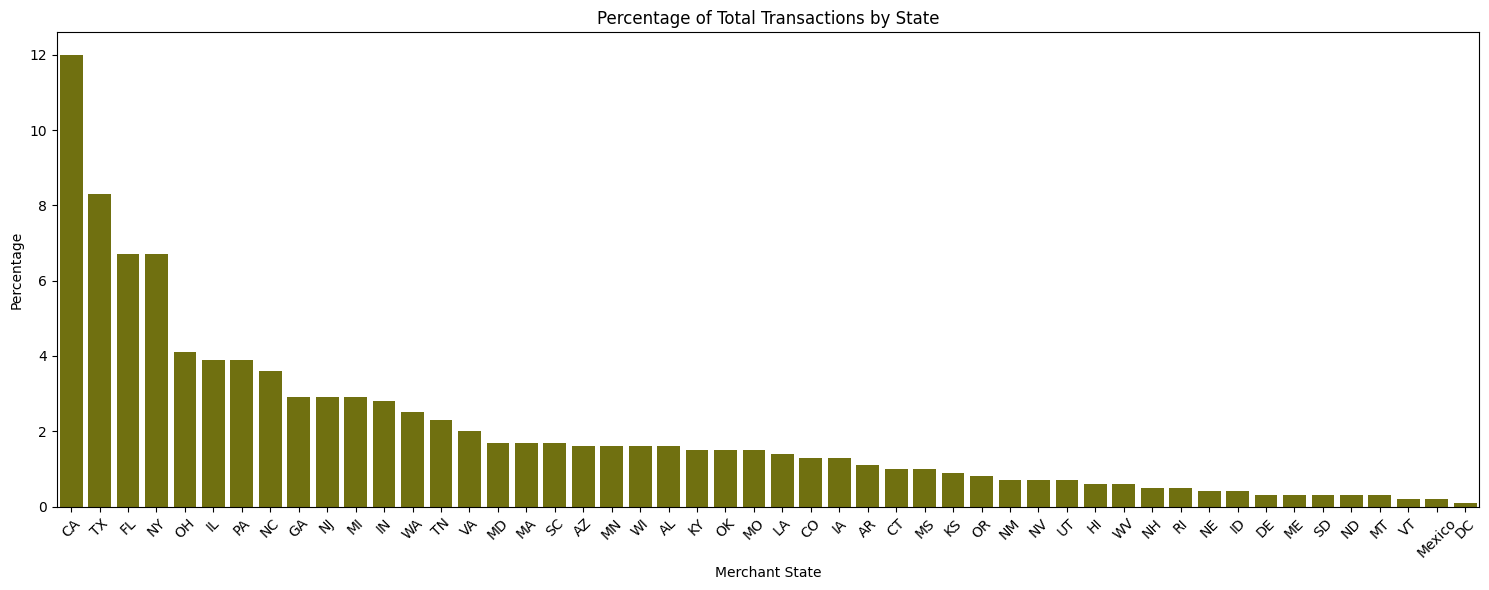

In [82]:
df_state_distribution = df_transactions.groupby(by = ['Merchant State']).agg(
    Transaction_Count = ('Is Fraud?', 'count')
).reset_index()
df_state_distribution['pct_of_total'] = round(df_state_distribution['Transaction_Count'] / df_state_distribution['Transaction_Count'].sum(), 3) * 100
df_state_distribution.sort_values(by = 'Transaction_Count', inplace = True, ascending = False)

# plot the pct of transactions by state
plt.figure(figsize=(15, 6))
sns.barplot(x = 'Merchant State',
            y = 'pct_of_total',
            color = 'olive',
           data = df_state_distribution.head(50))
plt.title('Percentage of Total Transactions by State')
plt.xlabel('Merchant State')
plt.ylabel('Percentage')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

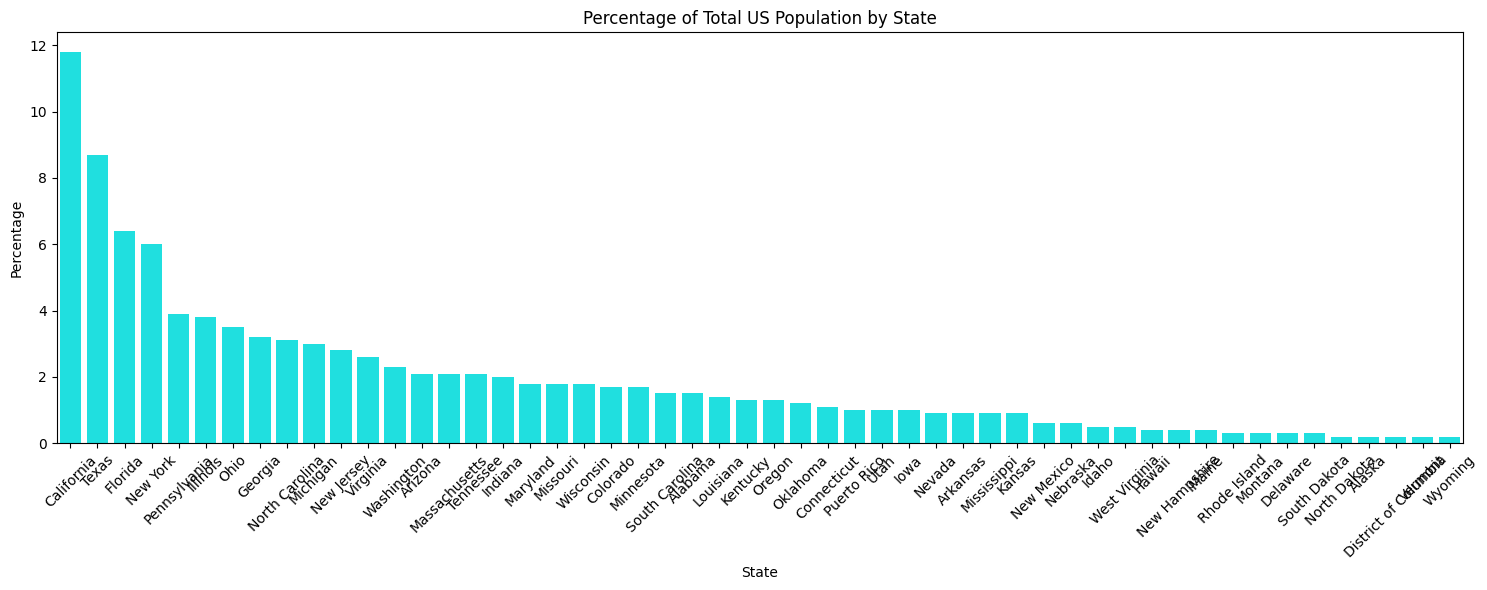

In [83]:
# look at US population data
df_usa_population = pd.read_csv('/content/gdrive/MyDrive/NST-EST2023-ALLDATA.csv')
df_usa_population_state = df_usa_population[df_usa_population['STATE'] != 0][['NAME', 'ESTIMATESBASE2020']].rename(
    columns = {'NAME': 'State',
               'ESTIMATESBASE2020': 'Population'})
df_usa_population_state['pct_of_total'] = round(df_usa_population_state['Population'] / df_usa_population_state['Population'].sum(), 3)*100
df_usa_population_state.sort_values(by = 'Population', ascending = False, inplace = True)
# plot the pct of population by state
plt.figure(figsize=(15, 6))
sns.barplot(x = 'State',
            y = 'pct_of_total',
            color = 'cyan',
           data = df_usa_population_state)
plt.title('Percentage of Total US Population by State')
plt.xlabel('State')
plt.ylabel('Percentage')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

* After looking at total transactions by state, we see that US states accounted for vast majority of the transactions, and significantly higher than non-US countries. This heavy concentration in the US states might not truly represent the distribution of true transactions.  
* Within U.S. we compared the transactions by the states to the US population by state data, and we found that the distribution of the sample is generally consistent with the overall US population, therefore we see no significant bias within the U.S.

#### Other representation biases
We also look at the distribution of transactions in MCC code category to look for any potential biases by certain MCC category.

In [84]:
# calculate transactions by MCC category
df_mcc_distribution = df_transactions.groupby(by = ['MCC']).agg(
    Transaction_Count = ('Is Fraud?', 'count')
).reset_index()

# # merge with the MCC mapping table
df_mcc_mapping = pd.read_csv('/content/gdrive/MyDrive/mcc_codes.csv')
df_mcc_distribution_mapped = df_mcc_distribution.merge(
    df_mcc_mapping[['mcc', 'edited_description']],
    how = 'left',
    left_on = 'MCC',
    right_on = 'mcc'
)
df_mcc_distribution_mapped = df_mcc_distribution_mapped.groupby(by = ['edited_description'])['Transaction_Count'].sum().reset_index()
df_mcc_distribution_mapped.sort_values(by = ['Transaction_Count'], ascending = False, inplace = True)
df_mcc_distribution_mapped['pct_of_total'] = round(df_mcc_distribution_mapped['Transaction_Count'] / df_mcc_distribution_mapped['Transaction_Count'].sum(), 3)*100

df_mcc_distribution_mapped.head(10)

,edited_description,Transaction_Count,pct_of_total
52,"Grocery Stores, Supermarkets",2860738,11.7
70,Misc. Food Stores – Convenience Stores and Spe...,2680609,11.0
88,Service Stations ( with or without ancillary s...,2638982,10.8
42,Eating places and Restaurants,1797920,7.4
40,Drug Stores and Pharmacies,1407636,5.8
72,Money Orders – Wire Transfer,1129061,4.6
96,Toll and Bridge Fees,1124291,4.6
102,Wholesale Clubs,1123037,4.6
94,Taxicabs and Limousines,981523,4.0
15,Automotive Service Shops,914630,3.8


By analyzing total transactions by MCC merchant categories, we can see that certain merchant categories carried a significantly higher percentage of transactions, such as grocery stores and convenience stores (combined 22.7% of total transactions), service stations like gas stations (10.8%), restaurants (7.4%), drug stores and pharmacies (5.8%), etc. The top 10 categories accounted for 68.3% of total number of transactions, and hence this might introduce bias towards these categories and the fraud activities in these categories might outweigh other less significant categories.    

#### Fraud Counts by MCC Category

In [85]:
# Fraud Transactions by MCC Category
df_mcc_fraud_distribution = df_transactions[df_transactions['Is Fraud?'] == 1].groupby(by = ['MCC']).agg(
    Transaction_Count = ('Is Fraud?', 'count')
).reset_index()

# # merge with the MCC mapping table
df_mcc_fraud_distribution_mapped = df_mcc_fraud_distribution.merge(
    df_mcc_mapping[['mcc', 'edited_description']],
    how = 'left',
    left_on = 'MCC',
    right_on = 'mcc'
)
df_mcc_fraud_distribution_mapped = df_mcc_fraud_distribution_mapped.groupby(by = ['edited_description'])['Transaction_Count'].sum().reset_index()
df_mcc_fraud_distribution_mapped.sort_values(by = ['Transaction_Count'], ascending = False, inplace = True)
df_mcc_fraud_distribution_mapped['pct_of_total'] = round(df_mcc_fraud_distribution_mapped['Transaction_Count'] / df_mcc_fraud_distribution_mapped['Transaction_Count'].sum(), 3)*100

df_mcc_fraud_distribution_mapped.head(10)

,edited_description,Transaction_Count,pct_of_total
31,Department Stores,4824,16.2
91,Wholesale Clubs,2201,7.4
34,Discount Stores,2152,7.2
65,Money Orders – Wire Transfer,1607,5.4
37,Drug Stores and Pharmacies,1057,3.6
48,"Grocery Stores, Supermarkets",943,3.2
33,"Digital Goods: Media, Books, Movies, Music",879,3.0
41,Family Clothing Stores,849,2.9
40,Electronic Sales,843,2.8
53,Hotels/Motels/Inns/Resorts,814,2.7


From above analysis, we learned that several MCC categories accounted for biggest share of fraud transactions, including Department Stores, Wholesale Clubs, Discount Stores, Money Orders, Wire Transfer, Drug Stores and Pharmacies, etc.

## Question 4: Fraud Prediction Model
Develop a model to predict fraudulent transactions. Discuss your choice of model and the considerations made during the modeling process.

#### Feature selections
Based on the EDA done previously, we will focus on variables that appeared to have more significant impact on fraud classification. Eliminating the variables with high percentage of missing value, or simply irrelevant. We've chosen the following variables for modelling:

* Predictor Variables: Year, Day of Week, Hour, Date, Amount, Use Chip, Merchant Name, Merchant City, Merchant State, MCC.
* Target Variable: **Is Fraud**

In [86]:
# Select feature columns
selected_columns = ['Year', 'Day of Week', 'Hour', 'Amount', 'Use Chip',
                    'Merchant Name', 'Merchant State', 'Merchant City', 'MCC', 'Is Fraud?']

df_transactions = df_transactions[selected_columns]

In [87]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Year            int64  
 1   Day of Week     object 
 2   Hour            int64  
 3   Amount          float64
 4   Use Chip        object 
 5   Merchant Name   int64  
 6   Merchant State  object 
 7   Merchant City   object 
 8   MCC             int64  
 9   Is Fraud?       int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 1.8+ GB


#### Preprocessing Pipeline

In [88]:
def clean(df):

    scaler = StandardScaler()
    df['Amount'] = scaler.fit_transform(df[['Amount']])
    df['Hour'] = df['Hour'].astype('int')
    df['Merchant State'].fillna('NA', inplace=True)
    df['Merchant State'] = df['Merchant State'].astype('category')
    # identify categorical columns
    cat_col = ['Day of Week', 'Merchant State','Use Chip', 'Merchant City']
    # use binary encoder to encode categorical values
    be = ce.BinaryEncoder(drop_invariant = False)
    enc_df= pd.DataFrame(be.fit_transform(df[cat_col]), dtype = 'int8')
    # drop old columns after transform
    df.drop(cat_col, axis=1, inplace = True)
    # merge with old df
    df = pd.concat([df, enc_df], axis=1)

    for col in df.columns:
        df[col] =  df[col].astype(float)

    return pd.DataFrame(df)

# create and apply the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean))
], verbose=True)

df_transactions_processed = preprocessing_pipeline.fit_transform(df_transactions)

[Pipeline] .......... (step 1 of 1) Processing cleaning, total= 1.6min


In [89]:
df_transactions_processed.head(10)

,Year,Hour,Amount,Merchant Name,MCC,Is Fraud?,Day of Week_0,Day of Week_1,Day of Week_2,Merchant State_0,...,Merchant City_4,Merchant City_5,Merchant City_6,Merchant City_7,Merchant City_8,Merchant City_9,Merchant City_10,Merchant City_11,Merchant City_12,Merchant City_13
0,2002.0,6.0,1.102821,3.527213e+18,5300.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2002.0,6.0,-0.062837,-7.276121e+17,5411.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2002.0,6.0,0.935184,-7.276121e+17,5411.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2002.0,17.0,1.040155,3.414527e+18,5651.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2002.0,6.0,0.744626,5.817218e+18,5912.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,2002.0,13.0,0.518834,-7.146671e+18,5970.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,2002.0,5.0,0.612101,-7.276121e+17,5411.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,2002.0,6.0,0.973710,-7.276121e+17,5411.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,2002.0,6.0,0.220501,-7.276121e+17,5411.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,2002.0,9.0,0.164175,4.055257e+18,7538.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [90]:
import gc
gc.collect()

10717

#### Data resampling (Undersampling)
Like we discussed in the earlier section, due to the significant data imbalance between fraud and non-fraud transactions (29757 fraud transactions vs. 24.4M non-fraud transactions), the 1000x difference between the two classes will likely introduce bias in the model towards non-fraud, and decreased model sensitivity to fraud cases. The model evaluation metric will also be misleading. Therefore we need to adjust the sampling data to give more fraud transactions to the training set and less non-fraud data.

In this case, due to the size of the dataset and compute and memory limit, we resampled 40,000 transactions, of which 8,000 were labeled fraud. This way we increased the proportion of the positive (fraud) cases significantly to reduce the chances of aformentioned biases in the model.

In [91]:
# show fraud vs. non-fraud transactions
df_transactions.groupby(by = 'Is Fraud?').size().reset_index()

,Is Fraud?,0
0,0,24357143
1,1,29757


In [92]:
gc.collect()

32061

In [93]:
# Split the dataset into features (X) and target variable (y)
X = df_transactions_processed.drop(columns=['Is Fraud?'])
y = df_transactions_processed['Is Fraud?']

# Calculate the desired number of fraud cases based on the desired proportion
desired_proportion = 0.2
total_samples = 40000
fraud_samples = int(total_samples * desired_proportion)

# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy = {0: total_samples - fraud_samples, 1: fraud_samples},
                         random_state = 42)

# Apply random undersampling to the original dataset
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 42)

#### Build a list of model candidates
Now we will experiment a list of ML models to detect fraud activities. Due to the nature of this analysis, the goal is to minimize false positives (legitimate transactions flagged as fraud) while maximizing the detection of actual fraudulent activities. Several classification models are known to be effective in this type of tasks:
* Logistic Regression
* Decision Trees
* Random Forest
* Gradient Boosting Machines (GBM): LightGBM, XGBoost, CatBoost  

In [94]:
model_list = {
    'Light GBM': LGBMClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Reg': LogisticRegression(),
    'XGBOOST': XGBClassifier(),
    'CatBoost' : CatBoostClassifier()
}

In [95]:
gc.collect()

0

#### Run models

In [96]:
### Train data and evaluate models for rough estimates on testing data to save time

models_scores = pd.DataFrame(columns=['model name', 'cross-val mean accuracy score'])

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results = pd.DataFrame()

for metric in metrics:
    for model_name, model in model_list.items():
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=metric, n_jobs=-1)

        # Store the results
        for fold_index, score in enumerate(cv_scores):
            results = results.append({
                'model': model_name,
                'metric': metric,
                'fold': fold_index,
                'score': score
            }, ignore_index=True)

# Calculate mean scores
mean_scores = results.groupby(['model', 'metric'])['score'].mean().unstack()


<ipython-input-96-b14fd1b302f9>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-96-b14fd1b302f9>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-96-b14fd1b302f9>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-96-b14fd1b302f9>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-96-b14fd1b302f9>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-i

In [97]:
# models_scores
mean_scores

metric,accuracy,f1,precision,recall,roc_auc
model,,,,,
CatBoost,0.965893,0.910642,0.959020,0.866963,0.988398
Decision Tree,0.935607,0.839949,0.822554,0.855031,0.904800
Light GBM,0.964357,0.906879,0.952212,0.865717,0.988175
Logistic Reg,0.520250,0.290638,0.206567,0.490116,0.532599
Random Forest,0.958857,0.892213,0.954530,0.837934,0.978884
XGBOOST,0.966429,0.912771,0.952748,0.876046,0.989117


<ipython-input-98-6087c59d7c07>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_scores.index, y=mean_scores[metric], palette="viridis")
<ipython-input-98-6087c59d7c07>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_scores.index, y=mean_scores[metric], palette="viridis")
<ipython-input-98-6087c59d7c07>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_scores.index, y=mean_scores[metric], palette="viridis")
<ipython-input-98-6087c59d7c07>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wil

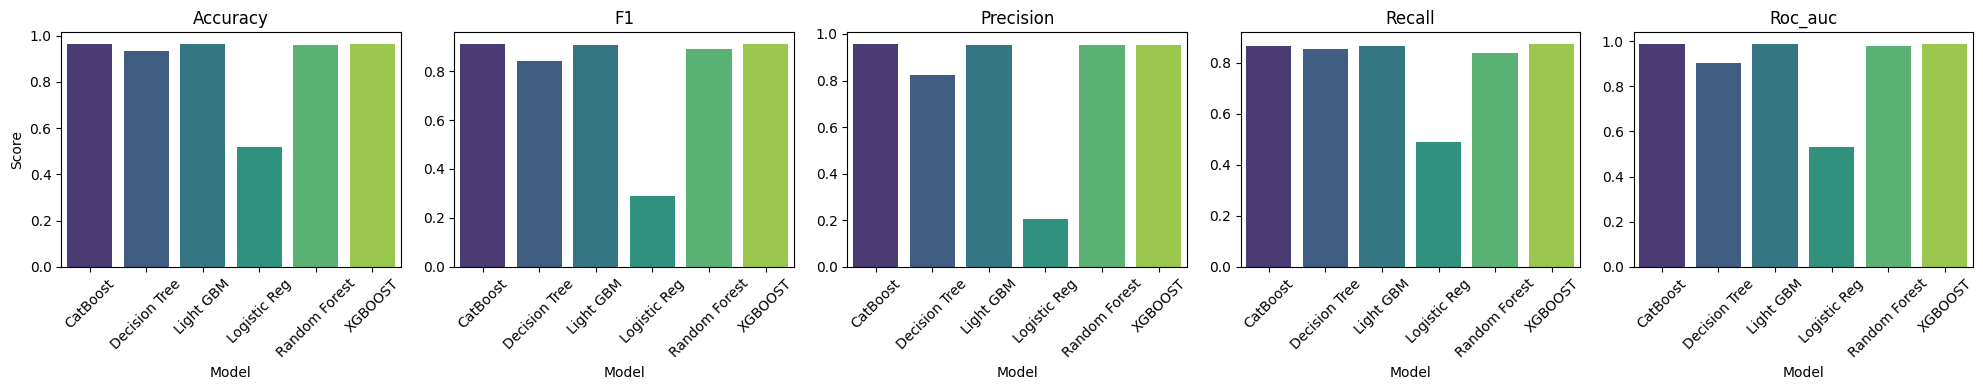

In [98]:

plt.figure(figsize=(20, 4))
# Iterate over each metric to create a subplot for each one
for i, metric in enumerate(mean_scores.columns):
    # Create a subplot position for each metric
    plt.subplot(1, len(mean_scores.columns), i+1)

    # Use Seaborn's barplot to plot each metric's mean score for all models
    sns.barplot(x=mean_scores.index, y=mean_scores[metric], palette="viridis")

    # Setting the title to the current metric
    plt.title(metric.capitalize())

    # Adding labels (modify as needed)
    plt.xlabel('Model')
    plt.ylabel('Score' if i == 0 else '')  # Only label y-axis for the first plot to avoid clutter

    # Optional: Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [99]:
gc.collect()

366

Looks like the initial results in mean metric scores for our models are pretty promising with 95%+ accuracy for all of them except for logistic regression model, similar for other metrics such as F1, precision, recall, and roc-auc area. Out of all the models, it appeared that XGBoost and CatBoost models were both performing very well across all metrics. We did notice that XGBoost was slightly better than CatBoost in 4 metrics except for precision which is only 0.007 below CatBoost model. Therefore we will pick XGBoost to tune due to the time limit for this project.

### Model tuning
For hyperparameter tuning for the XGBoost model, we use grid search cross validation to find the the most optimal parameters

In [100]:
# pick the model to tune
model = XGBClassifier()

# Define hyperparameters and their ranges
param_grid = {
    'n_estimators': [50, 150, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.5, 0.8, 1],
    'min_child_weight': [0, 3, 10]
}

# Configure GridSearchCV
# for simplicity reason, we will just use f1 score as the cross validation metric
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1}


## Question 5: Model Output Analysis
Examine the results of your model. Discuss the conclusions and insights you can derive from its output.  

In [101]:
# Use the tuned model to predict on test data
tuned_xgb_model = grid_search.best_estimator_
y_pred_xgb = tuned_xgb_model.predict(X_test)

# print the results
print("XGBoost Classifier Results After Tuning:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Classifier Results After Tuning:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      9615
         1.0       0.95      0.89      0.92      2385

    accuracy                           0.97     12000
   macro avg       0.96      0.94      0.95     12000
weighted avg       0.97      0.97      0.97     12000

[[9494  121]
 [ 253 2132]]


### Results evaluation

* Precision: A precision of 0.95 for class 1 means that 95% of the predicted fraud cases were actually fraudulent.

* Recall: A recall of 0.89 for class 1 means that the model identified 89% of the actual fraudulent transactions.

* F1-score: A F1-score of 0.92 indicates a good balance between precision and recall.

Overall, the model showed a high accuracy (95%) and performed well in classifying non-fraudulent transactions (class 0). Meanwhile, it showed a slightly lower recall (89%) for fraudulent transactions (class 1), indicating that it missed some fraudulent cases.

### Insights and Recommendations  

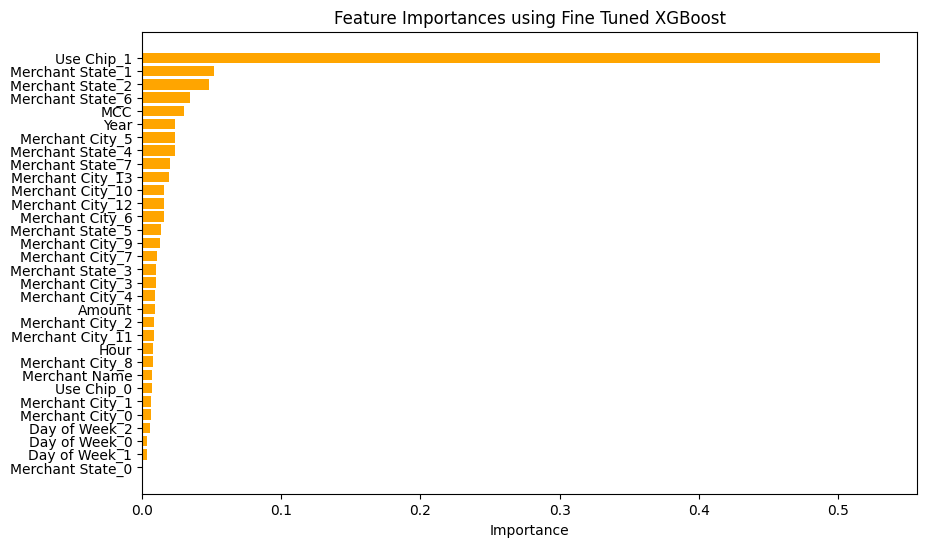

In [103]:
# Extract feature importances from the finetuned XGBoost model
feature_importance = tuned_xgb_model.feature_importances_
features = X_train.columns

# Sort the feature importances and their corresponding feature names
sorted_idx = feature_importance.argsort()

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], feature_importance[sorted_idx], align='center', color='orange')
plt.xlabel('Importance')
plt.title('Feature Importances using Fine Tuned XGBoost')
plt.show()

* Use_Chip_1 means **Online Transactions**, and this is far more impactful than any other factors in predicting transaction frauds. This means that online transactions might be more vulnerable compared to physical transactions like chip or swipe. This can be attributed to factors like phishing, weak password practices, or compromised databases.
* **Merchant State** 1, 2, 6, 4 are also important features, meaning that if transactions took place in those four states, namely OH, CA, TX, FL, the chances of encounting fraud are significantly higher.
* **MCC** is also an important feature. This indicated that certain merchant categories such as Department Stores, Wholesale Clubs, Discount Stores, Money Orders, Wire Transfer, Drug Stores and Pharmacies are prone to fraud likely because of frequent transaction volumes, higher ticket size.